## 0) 라이브러리 버전 확인하기

In [1]:
import tensorflow as tf
import numpy as np

print(tf.__version__)
print(np.__version__)

2.18.0
2.0.2


## 1) ResNet 기본 블록 구성하기

- ResNet-34와 ResNet-50 네트워크를 직접 만들기

In [2]:
from tensorflow.keras import layers, Model, Input

# 기본 conv + BN + ReLU 함수
def conv_bn_relu(x, filters, kernel_size, stride=1, name=None):
    x = layers.Conv2D(filters, kernel_size, strides=stride, padding='same', use_bias=False, name=f"{name}_conv")(x)
    x = layers.BatchNormalization(name=f"{name}_bn")(x)
    x = layers.Activation('relu', name=f"{name}_relu")(x)
    return x

In [3]:
# Basic Block (for ResNet-34 and PlainNet-34)
def basic_block(x, filters, stride=1, downsample=False, name=None, use_shortcut=True):
    shortcut = x

    x = conv_bn_relu(x, filters, 3, stride=stride, name=f"{name}_1")
    x = conv_bn_relu(x, filters, 3, stride=1, name=f"{name}_2")

    if use_shortcut:
        if downsample:
            shortcut = layers.Conv2D(filters, 1, strides=stride, use_bias=False, name=f"{name}_ds_conv")(shortcut)
            shortcut = layers.BatchNormalization(name=f"{name}_ds_bn")(shortcut)
        x = layers.Add(name=f"{name}_add")([x, shortcut])

    x = layers.Activation('relu', name=f"{name}_out")(x)
    return x



In [4]:
# Bottleneck Block (for ResNet-50 and PlainNet-50)
def bottleneck_block(x, filters, stride=1, downsample=False, name=None, use_shortcut=True):
    shortcut = x

    x = conv_bn_relu(x, filters, 1, stride=1, name=f"{name}_1")
    x = conv_bn_relu(x, filters, 3, stride=stride, name=f"{name}_2")
    x = conv_bn_relu(x, filters * 4, 1, stride=1, name=f"{name}_3")

    if use_shortcut:
        if downsample:
            shortcut = layers.Conv2D(filters * 4, 1, strides=stride, use_bias=False, name=f"{name}_ds_conv")(shortcut)
            shortcut = layers.BatchNormalization(name=f"{name}_ds_bn")(shortcut)
        x = layers.Add(name=f"{name}_add")([x, shortcut])

    x = layers.Activation('relu', name=f"{name}_out")(x)
    return x


In [5]:
# 공통 Stage 생성 함수
def make_stage(x, filters, blocks, stride, is_bottleneck, stage, use_shortcut=True):
    for i in range(blocks):
        block_name = f"stage{stage}_block{i}"
        if is_bottleneck:
            x = bottleneck_block(
                x, filters,
                stride=stride if i == 0 else 1,
                downsample=(i == 0),
                name=block_name,
                use_shortcut=use_shortcut
            )
        else:
            x = basic_block(
                x, filters,
                stride=stride if i == 0 else 1,
                downsample=(i == 0),
                name=block_name,
                use_shortcut=use_shortcut
            )
    return x

In [6]:
# ResNet 생성 함수
def build_resnet(input_shape=(224, 224, 3), is_50=False):
    input_tensor = Input(shape=input_shape)

    x = layers.Conv2D(64, 7, strides=2, padding='same', use_bias=False, name='conv1')(input_tensor)
    x = layers.BatchNormalization(name='conv1_bn')(x)
    x = layers.Activation('relu', name='conv1_relu')(x)
    x = layers.MaxPooling2D(pool_size=3, strides=2, padding='same', name='pool1')(x)

    block_configs = [3, 4, 6, 3]
    filters = [64, 128, 256, 512]

    for i, blocks in enumerate(block_configs):
        stride = 1 if i == 0 else 2
        x = make_stage(x, filters[i], blocks, stride, is_bottleneck=is_50, stage=i+2, use_shortcut=True)

    x = layers.GlobalAveragePooling2D(name='avg_pool')(x)
    x = layers.Dense(1, activation='sigmoid', name='fc')(x)

    model_name = 'resnet50' if is_50 else 'resnet34'
    return Model(inputs=input_tensor, outputs=x, name=model_name)

## 2) ResNet-34, ResNet-50 Complete Model

In [7]:
resnet_34 = build_resnet(input_shape=(32, 32,3), is_50=False)
resnet_34.summary()

Model: "resnet34"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 32, 32, 3) │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1 (Conv2D)      │ (None, 16, 16,    │      9,408 │ input_layer[0][0] │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_bn            │ (None, 16, 16,    │        256 │ conv1[0][0]       │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_relu          │ (None, 16, 16,    │          0 │ conv1_bn[0][0]    │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1               │ (None, 8, 8, 64)  │          0 │ conv1_relu[0][0]  │
│ (MaxPooling2D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stage2_block0_1_co… │ (None, 8, 8, 64)  │     36,864 │ pool1[0][0]       │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stage2_block0_1_bn  │ (None, 8, 8, 64)  │        256 │ stage2_block0_1_… │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stage2_block0_1_re… │ (None, 8, 8, 64)  │          0 │ stage2_block0_1_… │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stage2_block0_2_co… │ (None, 8, 8, 64)  │     36,864 │ stage2_block0_1_… │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stage2_block0_2_bn  │ (None, 8, 8, 64)  │        256 │ stage2_block0_2_… │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stage2_block0_ds_c… │ (None, 8, 8, 64)  │      4,096 │ pool1[0][0]       │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stage2_block0_2_re… │ (None, 8, 8, 64)  │          0 │ stage2_block0_2_… │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stage2_block0_ds_bn │ (None, 8, 8, 64)  │        256 │ stage2_block0_ds… │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stage2_block0_add   │ (None, 8, 8, 64)  │          0 │ stage2_block0_2_… │
│ (Add)               │                   │            │ stage2_block0_ds… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stage2_block0_out   │ (None, 8, 8, 64)  │          0 │ stage2_block0_ad… │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stage2_block1_1_co… │ (None, 8, 8, 64)  │     36,864 │ stage2_block0_ou… │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stage2_block1_1_bn  │ (None, 8, 8, 64)  │        256 │ stage2_block1_1_

 Total params: 21,306,561 (81.28 MB)

 Trainable params: 21,289,409 (81.21 MB)

 Non-trainable params: 17,152 (67.00 KB)

In [8]:
resnet_50 = build_resnet(input_shape=(32, 32,3), is_50=True)
resnet_50.summary()

Model: "resnet50"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 32, 32, 3) │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1 (Conv2D)      │ (None, 16, 16,    │      9,408 │ input_layer_1[0]… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_bn            │ (None, 16, 16,    │        256 │ conv1[0][0]       │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_relu          │ (None, 16, 16,    │          0 │ conv1_bn[0][0]    │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1               │ (None, 8, 8, 64)  │          0 │ conv1_relu[0][0]  │
│ (MaxPooling2D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stage2_block0_1_co… │ (None, 8, 8, 64)  │      4,096 │ pool1[0][0]       │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stage2_block0_1_bn  │ (None, 8, 8, 64)  │        256 │ stage2_block0_1_… │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stage2_block0_1_re… │ (None, 8, 8, 64)  │          0 │ stage2_block0_1_… │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stage2_block0_2_co… │ (None, 8, 8, 64)  │     36,864 │ stage2_block0_1_… │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stage2_block0_2_bn  │ (None, 8, 8, 64)  │        256 │ stage2_block0_2_… │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stage2_block0_2_re… │ (None, 8, 8, 64)  │          0 │ stage2_block0_2_… │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stage2_block0_3_co… │ (None, 8, 8, 256) │     16,384 │ stage2_block0_2_… │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stage2_block0_3_bn  │ (None, 8, 8, 256) │      1,024 │ stage2_block0_3_… │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stage2_block0_ds_c… │ (None, 8, 8, 256) │     16,384 │ pool1[0][0]       │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stage2_block0_3_re… │ (None, 8, 8, 256) │          0 │ stage2_block0_3_… │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stage2_block0_ds_bn │ (None, 8, 8, 256) │      1,024 │ stage2_block0_ds… │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stage2_block0_add   │ (None, 8, 8, 256) │          0 │ stage2_block0_3_

 Total params: 23,563,201 (89.89 MB)

 Trainable params: 23,510,081 (89.68 MB)

 Non-trainable params: 53,120 (207.50 KB)

## 3) 일반 네트워크(plain network) 만들기

In [9]:
# PlainNet 생성 함수
def build_plainnet(input_shape=(224, 224, 3), is_50=False):
    input_tensor = Input(shape=input_shape)

    x = layers.Conv2D(64, 7, strides=2, padding='same', use_bias=False, name='conv1')(input_tensor)
    x = layers.BatchNormalization(name='conv1_bn')(x)
    x = layers.Activation('relu', name='conv1_relu')(x)
    x = layers.MaxPooling2D(pool_size=3, strides=2, padding='same', name='pool1')(x)

    block_configs = [3, 4, 6, 3]
    filters = [64, 128, 256, 512]

    for i, blocks in enumerate(block_configs):
        stride = 1 if i == 0 else 2
        x = make_stage(x, filters[i], blocks, stride, is_bottleneck=is_50, stage=i+2, use_shortcut=False)

    x = layers.GlobalAveragePooling2D(name='avg_pool')(x)
    x = layers.Dense(1, activation='sigmoid', name='fc')(x)


    model_name = 'plain50' if is_50 else 'plain34'
    return Model(inputs=input_tensor, outputs=x, name=model_name)

In [10]:
plainnet_34 = build_plainnet(input_shape=(224, 224, 3), is_50=False)
plainnet_34.summary()

Model: "plain34"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1 (Conv2D)                  │ (None, 112, 112, 64)   │         9,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1_bn (BatchNormalization)   │ (None, 112, 112, 64)   │           256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1_relu (Activation)         │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ pool1 (MaxPooling2D)            │ (None, 56, 56, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ stage2_block0_1_conv (Conv2D)   │ (None, 56, 56, 64)     │        36,864 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ stage2_block0_1_bn              │ (None, 56, 56, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ stage2_block0_1_relu            │ (None, 56, 56, 64)     │             0 │
│ (Activation)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ stage2_block0_2_conv (Conv2D)   │ (None, 56, 56, 64)     │        36,864 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ stage2_block0_2_bn              │ (None, 56, 56, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ stage2_block0_2_relu            │ (None, 56, 56, 64)     │             0 │
│ (Activation)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ stage2_block0_out (Activation)  │ (None, 56, 56, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ stage2_block1_1_conv (Conv2D)   │ (None, 56, 56, 64)     │        36,864 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ stage2_block1_1_bn              │ (None, 56, 56, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ stage2_block1_1_relu            │ (None, 56, 56, 64)     │             0 │
│ (Activation)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ stage2_block1_2_conv (Conv2D)   │ (None, 56, 56, 64)     │        36,864 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ stage2_block1_2_bn              │ (None, 56, 56, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ stage2_block1_2_relu            │ (None, 56, 56, 64)     │             0 │
│ (Activation)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ stage2_block1_out (Activation)  │ (None, 56, 56, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ stage2_block2_1_conv (Conv2D)   │ (None, 56, 56, 64)     │        36,864 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ stage2_block2_1_bn              │ (None, 56, 56, 64)     │           25

 Total params: 21,126,593 (80.59 MB)

 Trainable params: 21,111,361 (80.53 MB)

 Non-trainable params: 15,232 (59.50 KB)

In [11]:
plainnet_50 = build_plainnet(input_shape=(224, 224, 3), is_50=True)
plainnet_50.summary()

Model: "plain50"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_3 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1 (Conv2D)                  │ (None, 112, 112, 64)   │         9,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1_bn (BatchNormalization)   │ (None, 112, 112, 64)   │           256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1_relu (Activation)         │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ pool1 (MaxPooling2D)            │ (None, 56, 56, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ stage2_block0_1_conv (Conv2D)   │ (None, 56, 56, 64)     │         4,096 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ stage2_block0_1_bn              │ (None, 56, 56, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ stage2_block0_1_relu            │ (None, 56, 56, 64)     │             0 │
│ (Activation)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ stage2_block0_2_conv (Conv2D)   │ (None, 56, 56, 64)     │        36,864 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ stage2_block0_2_bn              │ (None, 56, 56, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ stage2_block0_2_relu            │ (None, 56, 56, 64)     │             0 │
│ (Activation)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ stage2_block0_3_conv (Conv2D)   │ (None, 56, 56, 256)    │        16,384 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ stage2_block0_3_bn              │ (None, 56, 56, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ stage2_block0_3_relu            │ (None, 56, 56, 256)    │             0 │
│ (Activation)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ stage2_block0_out (Activation)  │ (None, 56, 56, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ stage2_block1_1_conv (Conv2D)   │ (None, 56, 56, 64)     │        16,384 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ stage2_block1_1_bn              │ (None, 56, 56, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ stage2_block1_1_relu            │ (None, 56, 56, 64)     │             0 │
│ (Activation)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ stage2_block1_2_conv (Conv2D)   │ (None, 56, 56, 64)     │        36,864 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ stage2_block1_2_bn              │ (None, 56, 56, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼─────────────

 Total params: 20,778,945 (79.27 MB)

 Trainable params: 20,733,505 (79.09 MB)

 Non-trainable params: 45,440 (177.50 KB)

## 4) ResNet-50 vs Plain-50 또는 ResNet-34 vs Plain-34

### ResNet-50 vs Plain-50

In [12]:
import tensorflow_datasets as tfds

# tfds 내부 링크 교체!
setattr(tfds.image_classification.cats_vs_dogs, '_URL',
        "https://download.microsoft.com/download/3/E/1/3E1C3F21-ECDB-4869-8368-6DEBA77B919F/kagglecatsanddogs_5340.zip")

In [13]:
# 데이터 로드
(ds_raw,), ds_info = tfds.load('cats_vs_dogs', split=['train'], as_supervised=True, with_info=True)

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Generating splits...:   0%|          | 0/1 [00:00<?, ? splits/s]

Generating train examples...: 0 examples [00:00, ? examples/s]

Shuffling /root/tensorflow_datasets/cats_vs_dogs/incomplete.4P79CA_4.0.1/cats_vs_dogs-train.tfrecord*...:   0%…

Dataset cats_vs_dogs downloaded and prepared to /root/tensorflow_datasets/cats_vs_dogs/4.0.1. Subsequent calls will reuse this data.


In [14]:
# 분할
total_count = ds_info.splits['train'].num_examples
train_count = int(total_count * 0.8)
ds_train = ds_raw.take(train_count)
ds_val = ds_raw.skip(train_count)

# 이미지 전처리
IMG_SIZE = 224
BATCH_SIZE = 32

In [15]:
def preprocess(image, label):
    image = tf.image.resize(image, [IMG_SIZE, IMG_SIZE])
    image = tf.cast(image, tf.float32) / 255.0
    return image, label

# 전처리 적용
ds_train = ds_train.map(preprocess).shuffle(1000).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
ds_val = ds_val.map(preprocess).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

In [16]:
for images, labels in ds_train.take(1):
    print("이미지 shape:", images.shape)
    print("라벨 shape:", labels.shape)
    print("라벨:", labels.numpy())


이미지 shape: (32, 224, 224, 3)
라벨 shape: (32,)
라벨: [0 1 1 1 1 1 0 1 1 0 1 1 0 1 1 1 0 0 0 1 1 0 0 0 1 1 1 1 1 1 0 1]


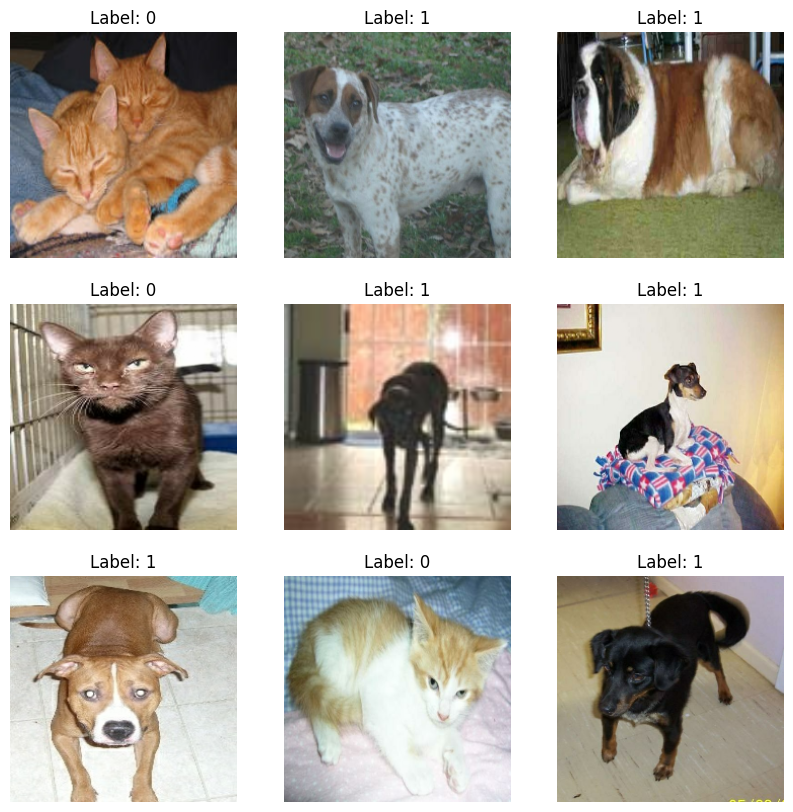

In [17]:
import matplotlib.pyplot as plt

for images, labels in ds_train.take(1):
    plt.figure(figsize=(10, 10))
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy())
        plt.title(f"Label: {labels[i].numpy()}")
        plt.axis("off")
    plt.show()


In [18]:
resnet_34 = build_resnet(input_shape=(224, 224, 3), is_50=False)
resnet_50 = build_resnet(input_shape=(224, 224, 3), is_50=True)

In [ ]:
# 모델 컴파일
resnet_50.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
plainnet_50.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# 학습 (간단히 5 epoch만)
EPOCHS = 5

history_resnet50 = resnet_50.fit(ds_train, validation_data=ds_val, epochs=EPOCHS)
history_plain50 = plainnet_50.fit(ds_train, validation_data=ds_val, epochs=EPOCHS)


Epoch 1/5
192/582 [========>.....................] - ETA: 2:29 - loss: 0.7975 - accuracy: 0.5905

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


229/582 [==========>...................] - ETA: 2:15 - loss: 0.7834 - accuracy: 0.5933

241/582 [===========>..................] - ETA: 2:10 - loss: 0.7800 - accuracy: 0.5923

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


285/582 [=============>................] - ETA: 1:53 - loss: 0.7664 - accuracy: 0.5910

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9


333/582 [================>.............] - ETA: 1:35 - loss: 0.7573 - accuracy: 0.5908

Corrupt JPEG data: 252 extraneous bytes before marker 0xd9


334/582 [================>.............] - ETA: 1:35 - loss: 0.7569 - accuracy: 0.5911

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


350/582 [=================>............] - ETA: 1:29 - loss: 0.7533 - accuracy: 0.5926

Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


510/582 [=========================>....] - ETA: 27s - loss: 0.7271 - accuracy: 0.5975

Corrupt JPEG data: 214 extraneous bytes before marker 0xd9


582/582 [==============================] - ETA: 0s - loss: 0.7227 - accuracy: 0.5972

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9
Corrupt JPEG data: 396 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 65 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9
Corrupt JPEG data: 128 extraneous bytes before marker 0xd9
Corrupt JPEG data: 239 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9
Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


582/582 [==============================] - 259s 429ms/step - loss: 0.7227 - accuracy: 0.5972 - val_loss: 0.9748 - val_accuracy: 0.5605
Epoch 2/5
192/582 [========>.....................] - ETA: 2:30 - loss: 0.6476 - accuracy: 0.6383

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


229/582 [==========>...................] - ETA: 2:16 - loss: 0.6488 - accuracy: 0.6396

241/582 [===========>..................] - ETA: 2:12 - loss: 0.6476 - accuracy: 0.6411

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


285/582 [=============>................] - ETA: 1:54 - loss: 0.6449 - accuracy: 0.6427

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9


333/582 [================>.............] - ETA: 1:36 - loss: 0.6451 - accuracy: 0.6447

Corrupt JPEG data: 252 extraneous bytes before marker 0xd9


334/582 [================>.............] - ETA: 1:35 - loss: 0.6450 - accuracy: 0.6443

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


350/582 [=================>............] - ETA: 1:29 - loss: 0.6433 - accuracy: 0.6455

Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


510/582 [=========================>....] - ETA: 27s - loss: 0.6356 - accuracy: 0.6493

Corrupt JPEG data: 214 extraneous bytes before marker 0xd9


582/582 [==============================] - ETA: 0s - loss: 0.6350 - accuracy: 0.6522

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9
Corrupt JPEG data: 396 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 65 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9
Corrupt JPEG data: 128 extraneous bytes before marker 0xd9
Corrupt JPEG data: 239 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9
Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


582/582 [==============================] - 248s 424ms/step - loss: 0.6350 - accuracy: 0.6522 - val_loss: 1.0184 - val_accuracy: 0.5652
Epoch 3/5
192/582 [========>.....................] - ETA: 2:31 - loss: 0.6017 - accuracy: 0.6834

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


229/582 [==========>...................] - ETA: 2:16 - loss: 0.5972 - accuracy: 0.6844

241/582 [===========>..................] - ETA: 2:12 - loss: 0.5937 - accuracy: 0.6854

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


285/582 [=============>................] - ETA: 1:55 - loss: 0.5921 - accuracy: 0.6872

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9


333/582 [================>.............] - ETA: 1:36 - loss: 0.5894 - accuracy: 0.6894

Corrupt JPEG data: 252 extraneous bytes before marker 0xd9


334/582 [================>.............] - ETA: 1:36 - loss: 0.5892 - accuracy: 0.6897

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


350/582 [=================>............] - ETA: 1:29 - loss: 0.5884 - accuracy: 0.6904

Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


510/582 [=========================>....] - ETA: 27s - loss: 0.5766 - accuracy: 0.6993

Corrupt JPEG data: 214 extraneous bytes before marker 0xd9


582/582 [==============================] - ETA: 0s - loss: 0.5702 - accuracy: 0.7038

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9
Corrupt JPEG data: 396 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 65 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9
Corrupt JPEG data: 128 extraneous bytes before marker 0xd9
Corrupt JPEG data: 239 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9
Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


582/582 [==============================] - 248s 425ms/step - loss: 0.5702 - accuracy: 0.7038 - val_loss: 0.7756 - val_accuracy: 0.5768
Epoch 4/5
192/582 [========>.....................] - ETA: 2:31 - loss: 0.5501 - accuracy: 0.7287

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


229/582 [==========>...................] - ETA: 2:16 - loss: 0.5466 - accuracy: 0.7290

241/582 [===========>..................] - ETA: 2:12 - loss: 0.5454 - accuracy: 0.7300

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


285/582 [=============>................] - ETA: 1:55 - loss: 0.5408 - accuracy: 0.7318

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9


333/582 [================>.............] - ETA: 1:36 - loss: 0.5343 - accuracy: 0.7360

Corrupt JPEG data: 252 extraneous bytes before marker 0xd9


334/582 [================>.............] - ETA: 1:36 - loss: 0.5341 - accuracy: 0.7360

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


350/582 [=================>............] - ETA: 1:29 - loss: 0.5344 - accuracy: 0.7360

Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


510/582 [=========================>....] - ETA: 27s - loss: 0.5264 - accuracy: 0.7393

Corrupt JPEG data: 214 extraneous bytes before marker 0xd9


582/582 [==============================] - ETA: 0s - loss: 0.5224 - accuracy: 0.7415

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9
Corrupt JPEG data: 396 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 65 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9
Corrupt JPEG data: 128 extraneous bytes before marker 0xd9
Corrupt JPEG data: 239 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9
Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


582/582 [==============================] - 248s 424ms/step - loss: 0.5224 - accuracy: 0.7415 - val_loss: 0.6987 - val_accuracy: 0.6708
Epoch 5/5
192/582 [========>.....................] - ETA: 2:31 - loss: 0.5064 - accuracy: 0.7562

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


229/582 [==========>...................] - ETA: 2:17 - loss: 0.4993 - accuracy: 0.7621

241/582 [===========>..................] - ETA: 2:12 - loss: 0.5010 - accuracy: 0.7604

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


285/582 [=============>................] - ETA: 1:55 - loss: 0.5020 - accuracy: 0.7594

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9


333/582 [================>.............] - ETA: 1:36 - loss: 0.4991 - accuracy: 0.7623

Corrupt JPEG data: 252 extraneous bytes before marker 0xd9


334/582 [================>.............] - ETA: 1:36 - loss: 0.4990 - accuracy: 0.7624

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


350/582 [=================>............] - ETA: 1:29 - loss: 0.4995 - accuracy: 0.7621

Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


510/582 [=========================>....] - ETA: 27s - loss: 0.4979 - accuracy: 0.7624

Corrupt JPEG data: 214 extraneous bytes before marker 0xd9


582/582 [==============================] - ETA: 0s - loss: 0.5004 - accuracy: 0.7607

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9
Corrupt JPEG data: 396 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 65 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9
Corrupt JPEG data: 128 extraneous bytes before marker 0xd9
Corrupt JPEG data: 239 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9
Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


582/582 [==============================] - 248s 425ms/step - loss: 0.5004 - accuracy: 0.7607 - val_loss: 15.4627 - val_accuracy: 0.5027
Epoch 1/5
192/582 [========>.....................] - ETA: 2:07 - loss: 0.7223 - accuracy: 0.4979

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


229/582 [==========>...................] - ETA: 1:55 - loss: 0.7186 - accuracy: 0.4980

241/582 [===========>..................] - ETA: 1:51 - loss: 0.7177 - accuracy: 0.4966

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


285/582 [=============>................] - ETA: 1:37 - loss: 0.7150 - accuracy: 0.4947

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9


333/582 [================>.............] - ETA: 1:21 - loss: 0.7122 - accuracy: 0.4997

Corrupt JPEG data: 252 extraneous bytes before marker 0xd9


334/582 [================>.............] - ETA: 1:21 - loss: 0.7122 - accuracy: 0.4996

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


350/582 [=================>............] - ETA: 1:15 - loss: 0.7117 - accuracy: 0.4995

Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


510/582 [=========================>....] - ETA: 23s - loss: 0.7092 - accuracy: 0.5036

Corrupt JPEG data: 214 extraneous bytes before marker 0xd9


582/582 [==============================] - ETA: 0s - loss: 0.7083 - accuracy: 0.5048

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9
Corrupt JPEG data: 396 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 65 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9
Corrupt JPEG data: 128 extraneous bytes before marker 0xd9
Corrupt JPEG data: 239 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9
Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


582/582 [==============================] - 215s 361ms/step - loss: 0.7083 - accuracy: 0.5048 - val_loss: 0.7248 - val_accuracy: 0.5128
Epoch 2/5
192/582 [========>.....................] - ETA: 2:07 - loss: 0.6945 - accuracy: 0.5332

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


229/582 [==========>...................] - ETA: 1:55 - loss: 0.6946 - accuracy: 0.5274

241/582 [===========>..................] - ETA: 1:51 - loss: 0.6933 - accuracy: 0.5312

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


285/582 [=============>................] - ETA: 1:37 - loss: 0.6907 - accuracy: 0.5402

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9


333/582 [================>.............] - ETA: 1:21 - loss: 0.6882 - accuracy: 0.5460

Corrupt JPEG data: 252 extraneous bytes before marker 0xd9


334/582 [================>.............] - ETA: 1:21 - loss: 0.6882 - accuracy: 0.5462

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


350/582 [=================>............] - ETA: 1:15 - loss: 0.6866 - accuracy: 0.5493

Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


510/582 [=========================>....] - ETA: 23s - loss: 0.6796 - accuracy: 0.5690

Corrupt JPEG data: 214 extraneous bytes before marker 0xd9


582/582 [==============================] - ETA: 0s - loss: 0.6782 - accuracy: 0.5733

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9
Corrupt JPEG data: 396 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 65 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9
Corrupt JPEG data: 128 extraneous bytes before marker 0xd9
Corrupt JPEG data: 239 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9
Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


582/582 [==============================] - 210s 360ms/step - loss: 0.6782 - accuracy: 0.5733 - val_loss: 0.7636 - val_accuracy: 0.5422
Epoch 3/5
192/582 [========>.....................] - ETA: 2:07 - loss: 0.6602 - accuracy: 0.6100

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


229/582 [==========>...................] - ETA: 1:55 - loss: 0.6615 - accuracy: 0.6084

241/582 [===========>..................] - ETA: 1:51 - loss: 0.6620 - accuracy: 0.6072

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


285/582 [=============>................] - ETA: 1:37 - loss: 0.6658 - accuracy: 0.5981

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9


333/582 [================>.............] - ETA: 1:21 - loss: 0.6690 - accuracy: 0.5874

Corrupt JPEG data: 252 extraneous bytes before marker 0xd9


334/582 [================>.............] - ETA: 1:21 - loss: 0.6690 - accuracy: 0.5868

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


350/582 [=================>............] - ETA: 1:15 - loss: 0.6695 - accuracy: 0.5860

Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


510/582 [=========================>....] - ETA: 23s - loss: 0.6713 - accuracy: 0.5841

Corrupt JPEG data: 214 extraneous bytes before marker 0xd9


582/582 [==============================] - ETA: 0s - loss: 0.6699 - accuracy: 0.5858

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9
Corrupt JPEG data: 396 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 65 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9
Corrupt JPEG data: 128 extraneous bytes before marker 0xd9
Corrupt JPEG data: 239 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9
Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


582/582 [==============================] - 210s 360ms/step - loss: 0.6699 - accuracy: 0.5858 - val_loss: 0.7008 - val_accuracy: 0.5536
Epoch 4/5
192/582 [========>.....................] - ETA: 2:07 - loss: 0.6559 - accuracy: 0.6180

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


229/582 [==========>...................] - ETA: 1:55 - loss: 0.6575 - accuracy: 0.6144

241/582 [===========>..................] - ETA: 1:51 - loss: 0.6583 - accuracy: 0.6127

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


285/582 [=============>................] - ETA: 1:37 - loss: 0.6573 - accuracy: 0.6127

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9


333/582 [================>.............] - ETA: 1:21 - loss: 0.6584 - accuracy: 0.6102

Corrupt JPEG data: 252 extraneous bytes before marker 0xd9


334/582 [================>.............] - ETA: 1:21 - loss: 0.6584 - accuracy: 0.6102

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


350/582 [=================>............] - ETA: 1:15 - loss: 0.6576 - accuracy: 0.6107

Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


510/582 [=========================>....] - ETA: 23s - loss: 0.6531 - accuracy: 0.6170

Corrupt JPEG data: 214 extraneous bytes before marker 0xd9


582/582 [==============================] - ETA: 0s - loss: 0.6533 - accuracy: 0.6162

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9
Corrupt JPEG data: 396 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 65 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9
Corrupt JPEG data: 128 extraneous bytes before marker 0xd9
Corrupt JPEG data: 239 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9
Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


582/582 [==============================] - 210s 359ms/step - loss: 0.6533 - accuracy: 0.6162 - val_loss: 0.7860 - val_accuracy: 0.5470
Epoch 5/5
192/582 [========>.....................] - ETA: 2:07 - loss: 0.6379 - accuracy: 0.6310

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


229/582 [==========>...................] - ETA: 1:55 - loss: 0.6363 - accuracy: 0.6380

241/582 [===========>..................] - ETA: 1:51 - loss: 0.6351 - accuracy: 0.6394

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


285/582 [=============>................] - ETA: 1:37 - loss: 0.6363 - accuracy: 0.6380

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9


333/582 [================>.............] - ETA: 1:21 - loss: 0.6338 - accuracy: 0.6415

Corrupt JPEG data: 252 extraneous bytes before marker 0xd9


334/582 [================>.............] - ETA: 1:21 - loss: 0.6342 - accuracy: 0.6411

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


350/582 [=================>............] - ETA: 1:15 - loss: 0.6326 - accuracy: 0.6438

Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


510/582 [=========================>....] - ETA: 23s - loss: 0.6378 - accuracy: 0.6378

Corrupt JPEG data: 214 extraneous bytes before marker 0xd9


582/582 [==============================] - ETA: 0s - loss: 0.6372 - accuracy: 0.6372

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9
Corrupt JPEG data: 396 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 65 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9
Corrupt JPEG data: 128 extraneous bytes before marker 0xd9
Corrupt JPEG data: 239 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9
Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


582/582 [==============================] - 210s 360ms/step - loss: 0.6372 - accuracy: 0.6372 - val_loss: 14.0612 - val_accuracy: 0.4965


In [ ]:
def plot_dual_error(history, label='Model', color='r'):
    epochs = range(1, len(history.history['accuracy']) + 1)
    train_error = [100 * (1 - acc) for acc in history.history['accuracy']]
    val_error = [100 * (1 - acc) for acc in history.history['val_accuracy']]

    # 얇은 선: train / 굵은 선: val
    plt.plot(epochs, train_error, linestyle='-', color=color, linewidth=1, label=f'{label} Train')
    plt.plot(epochs, val_error, linestyle='-', color=color, linewidth=2.5, label=f'{label} Val')


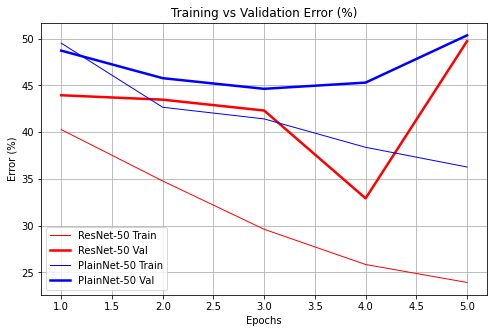

In [ ]:
plt.figure(figsize=(8, 5))
plot_dual_error(history_resnet50, label='ResNet-50', color='red')
plot_dual_error(history_plain50, label='PlainNet-50', color='blue')
plt.xlabel('Epochs')
plt.ylabel('Error (%)')
plt.title('Training vs Validation Error (%)')
plt.legend()
plt.grid(True)
plt.show()


In [ ]:
# 기존 모델에서 이어서 계속 학습
history_resnet50_continue = resnet_50.fit(
    ds_train,
    validation_data=ds_val,
    epochs=10,          # 총 epoch을 10으로 설정
    initial_epoch=5     # 이미 5번 돌았으므로 6번째부터 시작
)

history_plain50_continue = plainnet_50.fit(
    ds_train,
    validation_data=ds_val,
    epochs=10,
    initial_epoch=5
)


Epoch 6/10
192/582 [========>.....................] - ETA: 2:30 - loss: 0.4766 - accuracy: 0.7772

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


229/582 [==========>...................] - ETA: 2:15 - loss: 0.4772 - accuracy: 0.7796

241/582 [===========>..................] - ETA: 2:11 - loss: 0.4735 - accuracy: 0.7824

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


285/582 [=============>................] - ETA: 1:54 - loss: 0.4733 - accuracy: 0.7789

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9


333/582 [================>.............] - ETA: 1:35 - loss: 0.4714 - accuracy: 0.7800

Corrupt JPEG data: 252 extraneous bytes before marker 0xd9


334/582 [================>.............] - ETA: 1:35 - loss: 0.4714 - accuracy: 0.7801

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


350/582 [=================>............] - ETA: 1:29 - loss: 0.4695 - accuracy: 0.7813

Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


510/582 [=========================>....] - ETA: 27s - loss: 0.4648 - accuracy: 0.7836

Corrupt JPEG data: 214 extraneous bytes before marker 0xd9


582/582 [==============================] - ETA: 0s - loss: 0.4652 - accuracy: 0.7837

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9
Corrupt JPEG data: 396 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 65 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9
Corrupt JPEG data: 128 extraneous bytes before marker 0xd9
Corrupt JPEG data: 239 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9
Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


582/582 [==============================] - 247s 423ms/step - loss: 0.4652 - accuracy: 0.7837 - val_loss: 0.6618 - val_accuracy: 0.6978
Epoch 7/10
192/582 [========>.....................] - ETA: 2:30 - loss: 0.4409 - accuracy: 0.7977

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


229/582 [==========>...................] - ETA: 2:16 - loss: 0.4359 - accuracy: 0.8014

241/582 [===========>..................] - ETA: 2:12 - loss: 0.4345 - accuracy: 0.8024

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


285/582 [=============>................] - ETA: 1:54 - loss: 0.4374 - accuracy: 0.8005

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9


333/582 [================>.............] - ETA: 1:36 - loss: 0.4345 - accuracy: 0.8018

Corrupt JPEG data: 252 extraneous bytes before marker 0xd9


334/582 [================>.............] - ETA: 1:35 - loss: 0.4341 - accuracy: 0.8019

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


350/582 [=================>............] - ETA: 1:29 - loss: 0.4340 - accuracy: 0.8026

Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


510/582 [=========================>....] - ETA: 27s - loss: 0.4319 - accuracy: 0.8038

Corrupt JPEG data: 214 extraneous bytes before marker 0xd9


582/582 [==============================] - ETA: 0s - loss: 0.4282 - accuracy: 0.8053

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9
Corrupt JPEG data: 396 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 65 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9
Corrupt JPEG data: 128 extraneous bytes before marker 0xd9
Corrupt JPEG data: 239 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9
Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


582/582 [==============================] - 247s 424ms/step - loss: 0.4282 - accuracy: 0.8053 - val_loss: 0.5329 - val_accuracy: 0.7518
Epoch 8/10
192/582 [========>.....................] - ETA: 2:30 - loss: 0.4023 - accuracy: 0.8224

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


229/582 [==========>...................] - ETA: 2:16 - loss: 0.4070 - accuracy: 0.8206

241/582 [===========>..................] - ETA: 2:11 - loss: 0.4040 - accuracy: 0.8229

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


285/582 [=============>................] - ETA: 1:54 - loss: 0.3996 - accuracy: 0.8241

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9


333/582 [================>.............] - ETA: 1:36 - loss: 0.3980 - accuracy: 0.8242

Corrupt JPEG data: 252 extraneous bytes before marker 0xd9


334/582 [================>.............] - ETA: 1:35 - loss: 0.3980 - accuracy: 0.8241

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


350/582 [=================>............] - ETA: 1:29 - loss: 0.3970 - accuracy: 0.8252

Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


510/582 [=========================>....] - ETA: 27s - loss: 0.3901 - accuracy: 0.8278

Corrupt JPEG data: 214 extraneous bytes before marker 0xd9


582/582 [==============================] - ETA: 0s - loss: 0.3867 - accuracy: 0.8295

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9
Corrupt JPEG data: 396 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 65 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9
Corrupt JPEG data: 128 extraneous bytes before marker 0xd9
Corrupt JPEG data: 239 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9
Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


582/582 [==============================] - 247s 424ms/step - loss: 0.3867 - accuracy: 0.8295 - val_loss: 0.6730 - val_accuracy: 0.7838
Epoch 9/10
192/582 [========>.....................] - ETA: 2:30 - loss: 0.3686 - accuracy: 0.8400

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


229/582 [==========>...................] - ETA: 2:16 - loss: 0.3687 - accuracy: 0.8406

241/582 [===========>..................] - ETA: 2:11 - loss: 0.3673 - accuracy: 0.8417

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


285/582 [=============>................] - ETA: 1:54 - loss: 0.3659 - accuracy: 0.8421

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9


333/582 [================>.............] - ETA: 1:36 - loss: 0.3628 - accuracy: 0.8419

Corrupt JPEG data: 252 extraneous bytes before marker 0xd9


334/582 [================>.............] - ETA: 1:35 - loss: 0.3633 - accuracy: 0.8416

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


350/582 [=================>............] - ETA: 1:29 - loss: 0.3627 - accuracy: 0.8424

Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


510/582 [=========================>....] - ETA: 27s - loss: 0.3582 - accuracy: 0.8457

Corrupt JPEG data: 214 extraneous bytes before marker 0xd9


582/582 [==============================] - ETA: 0s - loss: 0.3560 - accuracy: 0.8465

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9
Corrupt JPEG data: 396 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 65 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9
Corrupt JPEG data: 128 extraneous bytes before marker 0xd9
Corrupt JPEG data: 239 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9
Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


582/582 [==============================] - 247s 424ms/step - loss: 0.3560 - accuracy: 0.8465 - val_loss: 0.9308 - val_accuracy: 0.6675
Epoch 10/10
192/582 [========>.....................] - ETA: 2:30 - loss: 0.3453 - accuracy: 0.8516

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


229/582 [==========>...................] - ETA: 2:16 - loss: 0.3406 - accuracy: 0.8536

241/582 [===========>..................] - ETA: 2:11 - loss: 0.3400 - accuracy: 0.8540

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


285/582 [=============>................] - ETA: 1:54 - loss: 0.3404 - accuracy: 0.8532

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9


333/582 [================>.............] - ETA: 1:36 - loss: 0.3338 - accuracy: 0.8562

Corrupt JPEG data: 252 extraneous bytes before marker 0xd9


334/582 [================>.............] - ETA: 1:35 - loss: 0.3336 - accuracy: 0.8561

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


350/582 [=================>............] - ETA: 1:29 - loss: 0.3321 - accuracy: 0.8572

Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


510/582 [=========================>....] - ETA: 27s - loss: 0.3214 - accuracy: 0.8632

Corrupt JPEG data: 214 extraneous bytes before marker 0xd9


582/582 [==============================] - ETA: 0s - loss: 0.3174 - accuracy: 0.8651

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9
Corrupt JPEG data: 396 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 65 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9
Corrupt JPEG data: 128 extraneous bytes before marker 0xd9
Corrupt JPEG data: 239 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9
Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


582/582 [==============================] - 247s 423ms/step - loss: 0.3174 - accuracy: 0.8651 - val_loss: 0.3157 - val_accuracy: 0.8635
Epoch 6/10
192/582 [========>.....................] - ETA: 2:07 - loss: 0.6255 - accuracy: 0.6541

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


229/582 [==========>...................] - ETA: 1:55 - loss: 0.6257 - accuracy: 0.6532

241/582 [===========>..................] - ETA: 1:51 - loss: 0.6267 - accuracy: 0.6535

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


285/582 [=============>................] - ETA: 1:36 - loss: 0.6245 - accuracy: 0.6568

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9


333/582 [================>.............] - ETA: 1:21 - loss: 0.6228 - accuracy: 0.6588

Corrupt JPEG data: 252 extraneous bytes before marker 0xd9


334/582 [================>.............] - ETA: 1:20 - loss: 0.6226 - accuracy: 0.6591

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


350/582 [=================>............] - ETA: 1:15 - loss: 0.6237 - accuracy: 0.6571

Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


510/582 [=========================>....] - ETA: 23s - loss: 0.6213 - accuracy: 0.6610

Corrupt JPEG data: 214 extraneous bytes before marker 0xd9


582/582 [==============================] - ETA: 0s - loss: 0.6206 - accuracy: 0.6626

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9
Corrupt JPEG data: 396 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 65 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9
Corrupt JPEG data: 128 extraneous bytes before marker 0xd9
Corrupt JPEG data: 239 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9
Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


582/582 [==============================] - 210s 359ms/step - loss: 0.6206 - accuracy: 0.6626 - val_loss: 0.7684 - val_accuracy: 0.6035
Epoch 7/10
192/582 [========>.....................] - ETA: 2:07 - loss: 0.6042 - accuracy: 0.6711

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


229/582 [==========>...................] - ETA: 1:55 - loss: 0.6051 - accuracy: 0.6714

241/582 [===========>..................] - ETA: 1:51 - loss: 0.6060 - accuracy: 0.6700

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


285/582 [=============>................] - ETA: 1:36 - loss: 0.6074 - accuracy: 0.6689

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9


333/582 [================>.............] - ETA: 1:21 - loss: 0.6094 - accuracy: 0.6671

Corrupt JPEG data: 252 extraneous bytes before marker 0xd9


334/582 [================>.............] - ETA: 1:20 - loss: 0.6099 - accuracy: 0.6666

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


350/582 [=================>............] - ETA: 1:15 - loss: 0.6112 - accuracy: 0.6651

Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


510/582 [=========================>....] - ETA: 23s - loss: 0.6054 - accuracy: 0.6724

Corrupt JPEG data: 214 extraneous bytes before marker 0xd9


582/582 [==============================] - ETA: 0s - loss: 0.6022 - accuracy: 0.6749

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9
Corrupt JPEG data: 396 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 65 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9
Corrupt JPEG data: 128 extraneous bytes before marker 0xd9
Corrupt JPEG data: 239 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9
Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


582/582 [==============================] - 210s 359ms/step - loss: 0.6022 - accuracy: 0.6749 - val_loss: 0.7449 - val_accuracy: 0.6200
Epoch 8/10
192/582 [========>.....................] - ETA: 2:07 - loss: 0.5819 - accuracy: 0.6969

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


229/582 [==========>...................] - ETA: 1:55 - loss: 0.5817 - accuracy: 0.6951

241/582 [===========>..................] - ETA: 1:51 - loss: 0.5815 - accuracy: 0.6958

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


285/582 [=============>................] - ETA: 1:37 - loss: 0.5812 - accuracy: 0.6973

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9


333/582 [================>.............] - ETA: 1:21 - loss: 0.5772 - accuracy: 0.7007

Corrupt JPEG data: 252 extraneous bytes before marker 0xd9


334/582 [================>.............] - ETA: 1:21 - loss: 0.5776 - accuracy: 0.7006

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


350/582 [=================>............] - ETA: 1:15 - loss: 0.5755 - accuracy: 0.7024

Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


510/582 [=========================>....] - ETA: 23s - loss: 0.5675 - accuracy: 0.7119

Corrupt JPEG data: 214 extraneous bytes before marker 0xd9


582/582 [==============================] - ETA: 0s - loss: 0.5666 - accuracy: 0.7129

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9
Corrupt JPEG data: 396 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 65 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9
Corrupt JPEG data: 128 extraneous bytes before marker 0xd9
Corrupt JPEG data: 239 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9
Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


582/582 [==============================] - 210s 359ms/step - loss: 0.5666 - accuracy: 0.7129 - val_loss: 0.9911 - val_accuracy: 0.5121
Epoch 9/10
192/582 [========>.....................] - ETA: 2:07 - loss: 0.5455 - accuracy: 0.7323

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


229/582 [==========>...................] - ETA: 1:55 - loss: 0.5519 - accuracy: 0.7275

241/582 [===========>..................] - ETA: 1:51 - loss: 0.5536 - accuracy: 0.7259

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


285/582 [=============>................] - ETA: 1:37 - loss: 0.5537 - accuracy: 0.7273

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9


333/582 [================>.............] - ETA: 1:21 - loss: 0.5494 - accuracy: 0.7296

Corrupt JPEG data: 252 extraneous bytes before marker 0xd9


334/582 [================>.............] - ETA: 1:21 - loss: 0.5496 - accuracy: 0.7296

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


350/582 [=================>............] - ETA: 1:15 - loss: 0.5486 - accuracy: 0.7295

Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


510/582 [=========================>....] - ETA: 23s - loss: 0.5408 - accuracy: 0.7357

Corrupt JPEG data: 214 extraneous bytes before marker 0xd9


582/582 [==============================] - ETA: 0s - loss: 0.5377 - accuracy: 0.7372

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9
Corrupt JPEG data: 396 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 65 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9
Corrupt JPEG data: 128 extraneous bytes before marker 0xd9
Corrupt JPEG data: 239 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9
Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


582/582 [==============================] - 210s 359ms/step - loss: 0.5377 - accuracy: 0.7372 - val_loss: 1.4798 - val_accuracy: 0.5601
Epoch 10/10
192/582 [========>.....................] - ETA: 2:07 - loss: 0.5257 - accuracy: 0.7480

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


229/582 [==========>...................] - ETA: 1:55 - loss: 0.5253 - accuracy: 0.7492

241/582 [===========>..................] - ETA: 1:51 - loss: 0.5274 - accuracy: 0.7481

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


285/582 [=============>................] - ETA: 1:37 - loss: 0.5250 - accuracy: 0.7503

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9


333/582 [================>.............] - ETA: 1:21 - loss: 0.5283 - accuracy: 0.7476

Corrupt JPEG data: 252 extraneous bytes before marker 0xd9


334/582 [================>.............] - ETA: 1:21 - loss: 0.5286 - accuracy: 0.7473

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


350/582 [=================>............] - ETA: 1:15 - loss: 0.5278 - accuracy: 0.7476

Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


510/582 [=========================>....] - ETA: 23s - loss: 0.5200 - accuracy: 0.7522

Corrupt JPEG data: 214 extraneous bytes before marker 0xd9


582/582 [==============================] - ETA: 0s - loss: 0.5149 - accuracy: 0.7546

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9
Corrupt JPEG data: 396 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 65 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9
Corrupt JPEG data: 128 extraneous bytes before marker 0xd9
Corrupt JPEG data: 239 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9
Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


582/582 [==============================] - 210s 359ms/step - loss: 0.5149 - accuracy: 0.7546 - val_loss: 1.0163 - val_accuracy: 0.6447


In [ ]:
# accuracy, val_accuracy 등 합치기
for key in history_resnet50.history.keys():
    history_resnet50.history[key].extend(history_resnet50_continue.history[key])
    history_plain50.history[key].extend(history_plain50_continue.history[key])


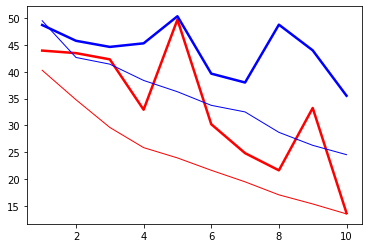

In [ ]:
plot_dual_error(history_resnet50, label='ResNet-50', color='red')
plot_dual_error(history_plain50, label='PlainNet-50', color='blue')


In [ ]:
# ResNet-50 계속 학습 (Epoch 11~20)
history_resnet50_continue2 = resnet_50.fit(
    ds_train,
    validation_data=ds_val,
    epochs=20,           # 총 목표 에폭
    initial_epoch=10     # 11번째 에폭부터 시작
)

# PlainNet-50 계속 학습 (Epoch 11~20)
history_plain50_continue2 = plainnet_50.fit(
    ds_train,
    validation_data=ds_val,
    epochs=20,
    initial_epoch=10
)


Epoch 11/20
192/582 [========>.....................] - ETA: 2:31 - loss: 0.2833 - accuracy: 0.8771

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


229/582 [==========>...................] - ETA: 2:16 - loss: 0.2812 - accuracy: 0.8766

241/582 [===========>..................] - ETA: 2:11 - loss: 0.2834 - accuracy: 0.8758

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


285/582 [=============>................] - ETA: 1:54 - loss: 0.2814 - accuracy: 0.8770

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9


333/582 [================>.............] - ETA: 1:36 - loss: 0.2806 - accuracy: 0.8762

Corrupt JPEG data: 252 extraneous bytes before marker 0xd9


334/582 [================>.............] - ETA: 1:35 - loss: 0.2804 - accuracy: 0.8763

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


350/582 [=================>............] - ETA: 1:29 - loss: 0.2807 - accuracy: 0.8763

Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


510/582 [=========================>....] - ETA: 27s - loss: 0.2763 - accuracy: 0.8795

Corrupt JPEG data: 214 extraneous bytes before marker 0xd9


582/582 [==============================] - ETA: 0s - loss: 0.2714 - accuracy: 0.8827

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9
Corrupt JPEG data: 396 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 65 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9
Corrupt JPEG data: 128 extraneous bytes before marker 0xd9
Corrupt JPEG data: 239 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9
Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


582/582 [==============================] - 247s 423ms/step - loss: 0.2714 - accuracy: 0.8827 - val_loss: 0.3976 - val_accuracy: 0.8401
Epoch 12/20
192/582 [========>.....................] - ETA: 2:30 - loss: 0.2656 - accuracy: 0.8900

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


229/582 [==========>...................] - ETA: 2:16 - loss: 0.2651 - accuracy: 0.8893

241/582 [===========>..................] - ETA: 2:11 - loss: 0.2640 - accuracy: 0.8897

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


285/582 [=============>................] - ETA: 1:54 - loss: 0.2607 - accuracy: 0.8918

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9


333/582 [================>.............] - ETA: 1:36 - loss: 0.2615 - accuracy: 0.8916

Corrupt JPEG data: 252 extraneous bytes before marker 0xd9


334/582 [================>.............] - ETA: 1:35 - loss: 0.2613 - accuracy: 0.8916

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


350/582 [=================>............] - ETA: 1:29 - loss: 0.2589 - accuracy: 0.8921

Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


510/582 [=========================>....] - ETA: 27s - loss: 0.2523 - accuracy: 0.8942

Corrupt JPEG data: 214 extraneous bytes before marker 0xd9


582/582 [==============================] - ETA: 0s - loss: 0.2495 - accuracy: 0.8951

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9
Corrupt JPEG data: 396 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 65 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9
Corrupt JPEG data: 128 extraneous bytes before marker 0xd9
Corrupt JPEG data: 239 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9
Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


582/582 [==============================] - 247s 423ms/step - loss: 0.2495 - accuracy: 0.8951 - val_loss: 1.0873 - val_accuracy: 0.5790
Epoch 13/20
192/582 [========>.....................] - ETA: 2:30 - loss: 0.2260 - accuracy: 0.9051

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


229/582 [==========>...................] - ETA: 2:16 - loss: 0.2250 - accuracy: 0.9068

241/582 [===========>..................] - ETA: 2:11 - loss: 0.2244 - accuracy: 0.9068

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


285/582 [=============>................] - ETA: 1:54 - loss: 0.2237 - accuracy: 0.9070

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9


333/582 [================>.............] - ETA: 1:36 - loss: 0.2251 - accuracy: 0.9071

Corrupt JPEG data: 252 extraneous bytes before marker 0xd9


334/582 [================>.............] - ETA: 1:35 - loss: 0.2259 - accuracy: 0.9068

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


350/582 [=================>............] - ETA: 1:29 - loss: 0.2243 - accuracy: 0.9075

Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


510/582 [=========================>....] - ETA: 27s - loss: 0.2195 - accuracy: 0.9089

Corrupt JPEG data: 214 extraneous bytes before marker 0xd9


582/582 [==============================] - ETA: 0s - loss: 0.2190 - accuracy: 0.9097

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9
Corrupt JPEG data: 396 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 65 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9
Corrupt JPEG data: 128 extraneous bytes before marker 0xd9
Corrupt JPEG data: 239 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9
Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


582/582 [==============================] - 247s 423ms/step - loss: 0.2190 - accuracy: 0.9097 - val_loss: 0.3009 - val_accuracy: 0.8728
Epoch 14/20
192/582 [========>.....................] - ETA: 2:30 - loss: 0.2043 - accuracy: 0.9168

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


229/582 [==========>...................] - ETA: 2:16 - loss: 0.2067 - accuracy: 0.9153

241/582 [===========>..................] - ETA: 2:11 - loss: 0.2066 - accuracy: 0.9157

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


285/582 [=============>................] - ETA: 1:54 - loss: 0.2051 - accuracy: 0.9156

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9


333/582 [================>.............] - ETA: 1:36 - loss: 0.2087 - accuracy: 0.9129

Corrupt JPEG data: 252 extraneous bytes before marker 0xd9


334/582 [================>.............] - ETA: 1:35 - loss: 0.2085 - accuracy: 0.9129

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


350/582 [=================>............] - ETA: 1:29 - loss: 0.2079 - accuracy: 0.9136

Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


510/582 [=========================>....] - ETA: 27s - loss: 0.2001 - accuracy: 0.9158

Corrupt JPEG data: 214 extraneous bytes before marker 0xd9


582/582 [==============================] - ETA: 0s - loss: 0.1985 - accuracy: 0.9173

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9
Corrupt JPEG data: 396 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 65 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9
Corrupt JPEG data: 128 extraneous bytes before marker 0xd9
Corrupt JPEG data: 239 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9
Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


582/582 [==============================] - 247s 424ms/step - loss: 0.1985 - accuracy: 0.9173 - val_loss: 0.3473 - val_accuracy: 0.8751
Epoch 15/20
192/582 [========>.....................] - ETA: 2:30 - loss: 0.1847 - accuracy: 0.9245

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


229/582 [==========>...................] - ETA: 2:16 - loss: 0.1919 - accuracy: 0.9214

241/582 [===========>..................] - ETA: 2:11 - loss: 0.1921 - accuracy: 0.9221

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


285/582 [=============>................] - ETA: 1:54 - loss: 0.1981 - accuracy: 0.9192

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9


333/582 [================>.............] - ETA: 1:36 - loss: 0.1977 - accuracy: 0.9190

Corrupt JPEG data: 252 extraneous bytes before marker 0xd9


334/582 [================>.............] - ETA: 1:35 - loss: 0.1972 - accuracy: 0.9193

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


350/582 [=================>............] - ETA: 1:29 - loss: 0.1956 - accuracy: 0.9205

Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


510/582 [=========================>....] - ETA: 27s - loss: 0.1900 - accuracy: 0.9220

Corrupt JPEG data: 214 extraneous bytes before marker 0xd9


582/582 [==============================] - ETA: 0s - loss: 0.1876 - accuracy: 0.9227

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9
Corrupt JPEG data: 396 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 65 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9
Corrupt JPEG data: 128 extraneous bytes before marker 0xd9
Corrupt JPEG data: 239 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9
Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


582/582 [==============================] - 247s 423ms/step - loss: 0.1876 - accuracy: 0.9227 - val_loss: 1.6020 - val_accuracy: 0.5960
Epoch 16/20
192/582 [========>.....................] - ETA: 2:30 - loss: 0.1694 - accuracy: 0.9290

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


229/582 [==========>...................] - ETA: 2:16 - loss: 0.1659 - accuracy: 0.9307

241/582 [===========>..................] - ETA: 2:11 - loss: 0.1650 - accuracy: 0.9317

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


285/582 [=============>................] - ETA: 1:54 - loss: 0.1697 - accuracy: 0.9296

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9


333/582 [================>.............] - ETA: 1:36 - loss: 0.1678 - accuracy: 0.9300

Corrupt JPEG data: 252 extraneous bytes before marker 0xd9


334/582 [================>.............] - ETA: 1:35 - loss: 0.1675 - accuracy: 0.9301

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


350/582 [=================>............] - ETA: 1:29 - loss: 0.1674 - accuracy: 0.9305

Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


510/582 [=========================>....] - ETA: 27s - loss: 0.1642 - accuracy: 0.9329

Corrupt JPEG data: 214 extraneous bytes before marker 0xd9


582/582 [==============================] - ETA: 0s - loss: 0.1611 - accuracy: 0.9344

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9
Corrupt JPEG data: 396 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 65 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9
Corrupt JPEG data: 128 extraneous bytes before marker 0xd9
Corrupt JPEG data: 239 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9
Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


582/582 [==============================] - 247s 423ms/step - loss: 0.1611 - accuracy: 0.9344 - val_loss: 0.3495 - val_accuracy: 0.8491
Epoch 17/20
192/582 [========>.....................] - ETA: 2:30 - loss: 0.1482 - accuracy: 0.9395

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


229/582 [==========>...................] - ETA: 2:16 - loss: 0.1457 - accuracy: 0.9415

241/582 [===========>..................] - ETA: 2:11 - loss: 0.1468 - accuracy: 0.9411

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


285/582 [=============>................] - ETA: 1:54 - loss: 0.1511 - accuracy: 0.9393

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9


333/582 [================>.............] - ETA: 1:36 - loss: 0.1501 - accuracy: 0.9397

Corrupt JPEG data: 252 extraneous bytes before marker 0xd9


334/582 [================>.............] - ETA: 1:35 - loss: 0.1501 - accuracy: 0.9397

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


350/582 [=================>............] - ETA: 1:29 - loss: 0.1510 - accuracy: 0.9395

Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


510/582 [=========================>....] - ETA: 27s - loss: 0.1439 - accuracy: 0.9425

Corrupt JPEG data: 214 extraneous bytes before marker 0xd9


582/582 [==============================] - ETA: 0s - loss: 0.1402 - accuracy: 0.9445

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9
Corrupt JPEG data: 396 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 65 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9
Corrupt JPEG data: 128 extraneous bytes before marker 0xd9
Corrupt JPEG data: 239 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9
Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


582/582 [==============================] - 247s 423ms/step - loss: 0.1402 - accuracy: 0.9445 - val_loss: 0.2341 - val_accuracy: 0.9057
Epoch 18/20
192/582 [========>.....................] - ETA: 2:30 - loss: 0.1408 - accuracy: 0.9440

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


229/582 [==========>...................] - ETA: 2:16 - loss: 0.1362 - accuracy: 0.9460

241/582 [===========>..................] - ETA: 2:11 - loss: 0.1360 - accuracy: 0.9463

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


285/582 [=============>................] - ETA: 1:54 - loss: 0.1320 - accuracy: 0.9484

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9


333/582 [================>.............] - ETA: 1:36 - loss: 0.1334 - accuracy: 0.9471

Corrupt JPEG data: 252 extraneous bytes before marker 0xd9


334/582 [================>.............] - ETA: 1:35 - loss: 0.1334 - accuracy: 0.9470

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


350/582 [=================>............] - ETA: 1:29 - loss: 0.1333 - accuracy: 0.9470

Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


510/582 [=========================>....] - ETA: 27s - loss: 0.1299 - accuracy: 0.9480

Corrupt JPEG data: 214 extraneous bytes before marker 0xd9


582/582 [==============================] - ETA: 0s - loss: 0.1292 - accuracy: 0.9483

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9
Corrupt JPEG data: 396 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 65 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9
Corrupt JPEG data: 128 extraneous bytes before marker 0xd9
Corrupt JPEG data: 239 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9
Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


582/582 [==============================] - 247s 423ms/step - loss: 0.1292 - accuracy: 0.9483 - val_loss: 0.5018 - val_accuracy: 0.8242
Epoch 19/20
192/582 [========>.....................] - ETA: 2:30 - loss: 0.1240 - accuracy: 0.9505

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


229/582 [==========>...................] - ETA: 2:16 - loss: 0.1209 - accuracy: 0.9514

241/582 [===========>..................] - ETA: 2:11 - loss: 0.1202 - accuracy: 0.9522

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


285/582 [=============>................] - ETA: 1:54 - loss: 0.1230 - accuracy: 0.9512

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9


333/582 [================>.............] - ETA: 1:36 - loss: 0.1234 - accuracy: 0.9512

Corrupt JPEG data: 252 extraneous bytes before marker 0xd9


334/582 [================>.............] - ETA: 1:35 - loss: 0.1231 - accuracy: 0.9513

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


350/582 [=================>............] - ETA: 1:29 - loss: 0.1233 - accuracy: 0.9513

Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


510/582 [=========================>....] - ETA: 27s - loss: 0.1165 - accuracy: 0.9537

Corrupt JPEG data: 214 extraneous bytes before marker 0xd9


582/582 [==============================] - ETA: 0s - loss: 0.1101 - accuracy: 0.9565

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9
Corrupt JPEG data: 396 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 65 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9
Corrupt JPEG data: 128 extraneous bytes before marker 0xd9
Corrupt JPEG data: 239 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9
Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


582/582 [==============================] - 247s 423ms/step - loss: 0.1101 - accuracy: 0.9565 - val_loss: 0.2533 - val_accuracy: 0.9076
Epoch 20/20
192/582 [========>.....................] - ETA: 2:30 - loss: 0.1052 - accuracy: 0.9595

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


229/582 [==========>...................] - ETA: 2:16 - loss: 0.1060 - accuracy: 0.9587

241/582 [===========>..................] - ETA: 2:11 - loss: 0.1052 - accuracy: 0.9590

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


285/582 [=============>................] - ETA: 1:54 - loss: 0.1045 - accuracy: 0.9589

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9


333/582 [================>.............] - ETA: 1:36 - loss: 0.1038 - accuracy: 0.9598

Corrupt JPEG data: 252 extraneous bytes before marker 0xd9


334/582 [================>.............] - ETA: 1:35 - loss: 0.1038 - accuracy: 0.9598

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


350/582 [=================>............] - ETA: 1:29 - loss: 0.1026 - accuracy: 0.9604

Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


510/582 [=========================>....] - ETA: 27s - loss: 0.1038 - accuracy: 0.9595

Corrupt JPEG data: 214 extraneous bytes before marker 0xd9


582/582 [==============================] - ETA: 0s - loss: 0.1033 - accuracy: 0.9595

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9
Corrupt JPEG data: 396 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 65 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9
Corrupt JPEG data: 128 extraneous bytes before marker 0xd9
Corrupt JPEG data: 239 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9
Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


582/582 [==============================] - 247s 423ms/step - loss: 0.1033 - accuracy: 0.9595 - val_loss: 0.4476 - val_accuracy: 0.8659
Epoch 11/20
192/582 [========>.....................] - ETA: 2:07 - loss: 0.4747 - accuracy: 0.7777

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


229/582 [==========>...................] - ETA: 1:55 - loss: 0.4761 - accuracy: 0.7751

241/582 [===========>..................] - ETA: 1:51 - loss: 0.4769 - accuracy: 0.7753

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


285/582 [=============>................] - ETA: 1:37 - loss: 0.4796 - accuracy: 0.7728

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9


333/582 [================>.............] - ETA: 1:21 - loss: 0.4755 - accuracy: 0.7766

Corrupt JPEG data: 252 extraneous bytes before marker 0xd9


334/582 [================>.............] - ETA: 1:21 - loss: 0.4756 - accuracy: 0.7764

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


350/582 [=================>............] - ETA: 1:15 - loss: 0.4754 - accuracy: 0.7772

Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


510/582 [=========================>....] - ETA: 23s - loss: 0.4745 - accuracy: 0.7798

Corrupt JPEG data: 214 extraneous bytes before marker 0xd9


582/582 [==============================] - ETA: 0s - loss: 0.4696 - accuracy: 0.7822

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9
Corrupt JPEG data: 396 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 65 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9
Corrupt JPEG data: 128 extraneous bytes before marker 0xd9
Corrupt JPEG data: 239 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9
Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


582/582 [==============================] - 210s 360ms/step - loss: 0.4696 - accuracy: 0.7822 - val_loss: 0.6115 - val_accuracy: 0.7507
Epoch 12/20
192/582 [========>.....................] - ETA: 2:07 - loss: 0.4466 - accuracy: 0.7948

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


229/582 [==========>...................] - ETA: 1:55 - loss: 0.4497 - accuracy: 0.7934

241/582 [===========>..................] - ETA: 1:51 - loss: 0.4494 - accuracy: 0.7937

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


285/582 [=============>................] - ETA: 1:37 - loss: 0.4482 - accuracy: 0.7940

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9


333/582 [================>.............] - ETA: 1:21 - loss: 0.4506 - accuracy: 0.7906

Corrupt JPEG data: 252 extraneous bytes before marker 0xd9


334/582 [================>.............] - ETA: 1:21 - loss: 0.4505 - accuracy: 0.7907

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


350/582 [=================>............] - ETA: 1:15 - loss: 0.4488 - accuracy: 0.7924

Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


510/582 [=========================>....] - ETA: 23s - loss: 0.4496 - accuracy: 0.7936

Corrupt JPEG data: 214 extraneous bytes before marker 0xd9


582/582 [==============================] - ETA: 0s - loss: 0.4458 - accuracy: 0.7961

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9
Corrupt JPEG data: 396 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 65 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9
Corrupt JPEG data: 128 extraneous bytes before marker 0xd9
Corrupt JPEG data: 239 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9
Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


582/582 [==============================] - 210s 359ms/step - loss: 0.4458 - accuracy: 0.7961 - val_loss: 0.7204 - val_accuracy: 0.7522
Epoch 13/20
192/582 [========>.....................] - ETA: 2:07 - loss: 0.4257 - accuracy: 0.8031

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


229/582 [==========>...................] - ETA: 1:55 - loss: 0.4296 - accuracy: 0.8021

241/582 [===========>..................] - ETA: 1:51 - loss: 0.4289 - accuracy: 0.8032

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


285/582 [=============>................] - ETA: 1:37 - loss: 0.4255 - accuracy: 0.8066

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9


333/582 [================>.............] - ETA: 1:21 - loss: 0.4227 - accuracy: 0.8078

Corrupt JPEG data: 252 extraneous bytes before marker 0xd9


334/582 [================>.............] - ETA: 1:21 - loss: 0.4229 - accuracy: 0.8078

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


350/582 [=================>............] - ETA: 1:15 - loss: 0.4227 - accuracy: 0.8084

Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


510/582 [=========================>....] - ETA: 23s - loss: 0.4239 - accuracy: 0.8083

Corrupt JPEG data: 214 extraneous bytes before marker 0xd9


582/582 [==============================] - ETA: 0s - loss: 0.4182 - accuracy: 0.8114

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9
Corrupt JPEG data: 396 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 65 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9
Corrupt JPEG data: 128 extraneous bytes before marker 0xd9
Corrupt JPEG data: 239 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9
Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


582/582 [==============================] - 210s 359ms/step - loss: 0.4182 - accuracy: 0.8114 - val_loss: 0.4394 - val_accuracy: 0.8102
Epoch 14/20
192/582 [========>.....................] - ETA: 2:07 - loss: 0.3996 - accuracy: 0.8195

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


229/582 [==========>...................] - ETA: 1:55 - loss: 0.4013 - accuracy: 0.8199

241/582 [===========>..................] - ETA: 1:51 - loss: 0.3981 - accuracy: 0.8212

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


285/582 [=============>................] - ETA: 1:37 - loss: 0.3994 - accuracy: 0.8194

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9


333/582 [================>.............] - ETA: 1:21 - loss: 0.3967 - accuracy: 0.8209

Corrupt JPEG data: 252 extraneous bytes before marker 0xd9


334/582 [================>.............] - ETA: 1:21 - loss: 0.3969 - accuracy: 0.8207

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


350/582 [=================>............] - ETA: 1:15 - loss: 0.3951 - accuracy: 0.8222

Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


510/582 [=========================>....] - ETA: 23s - loss: 0.3915 - accuracy: 0.8267

Corrupt JPEG data: 214 extraneous bytes before marker 0xd9


582/582 [==============================] - ETA: 0s - loss: 0.3884 - accuracy: 0.8281

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9
Corrupt JPEG data: 396 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 65 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9
Corrupt JPEG data: 128 extraneous bytes before marker 0xd9
Corrupt JPEG data: 239 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9
Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


582/582 [==============================] - 210s 359ms/step - loss: 0.3884 - accuracy: 0.8281 - val_loss: 2.3731 - val_accuracy: 0.5478
Epoch 15/20
192/582 [========>.....................] - ETA: 2:07 - loss: 0.3565 - accuracy: 0.8405

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


229/582 [==========>...................] - ETA: 1:55 - loss: 0.3555 - accuracy: 0.8420

241/582 [===========>..................] - ETA: 1:51 - loss: 0.3560 - accuracy: 0.8412

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


285/582 [=============>................] - ETA: 1:37 - loss: 0.3548 - accuracy: 0.8439

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9


333/582 [================>.............] - ETA: 1:21 - loss: 0.3571 - accuracy: 0.8438

Corrupt JPEG data: 252 extraneous bytes before marker 0xd9


334/582 [================>.............] - ETA: 1:21 - loss: 0.3569 - accuracy: 0.8437

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


350/582 [=================>............] - ETA: 1:15 - loss: 0.3574 - accuracy: 0.8434

Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


510/582 [=========================>....] - ETA: 23s - loss: 0.3548 - accuracy: 0.8463

Corrupt JPEG data: 214 extraneous bytes before marker 0xd9


582/582 [==============================] - ETA: 0s - loss: 0.3517 - accuracy: 0.8475

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9
Corrupt JPEG data: 396 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 65 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9
Corrupt JPEG data: 128 extraneous bytes before marker 0xd9
Corrupt JPEG data: 239 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9
Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


582/582 [==============================] - 210s 360ms/step - loss: 0.3517 - accuracy: 0.8475 - val_loss: 0.6005 - val_accuracy: 0.7167
Epoch 16/20
192/582 [========>.....................] - ETA: 2:07 - loss: 0.3415 - accuracy: 0.8568

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


229/582 [==========>...................] - ETA: 1:55 - loss: 0.3375 - accuracy: 0.8579

241/582 [===========>..................] - ETA: 1:51 - loss: 0.3384 - accuracy: 0.8579

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


285/582 [=============>................] - ETA: 1:36 - loss: 0.3368 - accuracy: 0.8592

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9


333/582 [================>.............] - ETA: 1:21 - loss: 0.3371 - accuracy: 0.8580

Corrupt JPEG data: 252 extraneous bytes before marker 0xd9


334/582 [================>.............] - ETA: 1:20 - loss: 0.3369 - accuracy: 0.8580

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


350/582 [=================>............] - ETA: 1:15 - loss: 0.3355 - accuracy: 0.8582

Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


510/582 [=========================>....] - ETA: 23s - loss: 0.3342 - accuracy: 0.8572

Corrupt JPEG data: 214 extraneous bytes before marker 0xd9


582/582 [==============================] - ETA: 0s - loss: 0.3319 - accuracy: 0.8579

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9
Corrupt JPEG data: 396 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 65 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9
Corrupt JPEG data: 128 extraneous bytes before marker 0xd9
Corrupt JPEG data: 239 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9
Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


582/582 [==============================] - 210s 359ms/step - loss: 0.3319 - accuracy: 0.8579 - val_loss: 4.2198 - val_accuracy: 0.5276
Epoch 17/20
192/582 [========>.....................] - ETA: 2:07 - loss: 0.3121 - accuracy: 0.8597

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


229/582 [==========>...................] - ETA: 1:55 - loss: 0.3123 - accuracy: 0.8597

241/582 [===========>..................] - ETA: 1:51 - loss: 0.3091 - accuracy: 0.8618

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


285/582 [=============>................] - ETA: 1:37 - loss: 0.3091 - accuracy: 0.8635

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9


333/582 [================>.............] - ETA: 1:21 - loss: 0.3115 - accuracy: 0.8634

Corrupt JPEG data: 252 extraneous bytes before marker 0xd9


334/582 [================>.............] - ETA: 1:21 - loss: 0.3113 - accuracy: 0.8636

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


350/582 [=================>............] - ETA: 1:15 - loss: 0.3121 - accuracy: 0.8625

Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


510/582 [=========================>....] - ETA: 23s - loss: 0.3102 - accuracy: 0.8634

Corrupt JPEG data: 214 extraneous bytes before marker 0xd9


582/582 [==============================] - ETA: 0s - loss: 0.3062 - accuracy: 0.8658

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9
Corrupt JPEG data: 396 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 65 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9
Corrupt JPEG data: 128 extraneous bytes before marker 0xd9
Corrupt JPEG data: 239 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9
Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


582/582 [==============================] - 210s 360ms/step - loss: 0.3062 - accuracy: 0.8658 - val_loss: 0.6124 - val_accuracy: 0.8119
Epoch 18/20
192/582 [========>.....................] - ETA: 2:07 - loss: 0.2894 - accuracy: 0.8768

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


229/582 [==========>...................] - ETA: 1:55 - loss: 0.2893 - accuracy: 0.8766

241/582 [===========>..................] - ETA: 1:51 - loss: 0.2880 - accuracy: 0.8771

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


285/582 [=============>................] - ETA: 1:37 - loss: 0.2856 - accuracy: 0.8788

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9


333/582 [================>.............] - ETA: 1:21 - loss: 0.2849 - accuracy: 0.8797

Corrupt JPEG data: 252 extraneous bytes before marker 0xd9


334/582 [================>.............] - ETA: 1:21 - loss: 0.2852 - accuracy: 0.8792

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


350/582 [=================>............] - ETA: 1:15 - loss: 0.2836 - accuracy: 0.8801

Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


510/582 [=========================>....] - ETA: 23s - loss: 0.2870 - accuracy: 0.8784

Corrupt JPEG data: 214 extraneous bytes before marker 0xd9


582/582 [==============================] - ETA: 0s - loss: 0.2809 - accuracy: 0.8802

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9
Corrupt JPEG data: 396 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 65 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9
Corrupt JPEG data: 128 extraneous bytes before marker 0xd9
Corrupt JPEG data: 239 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9
Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


582/582 [==============================] - 210s 360ms/step - loss: 0.2809 - accuracy: 0.8802 - val_loss: 2.4299 - val_accuracy: 0.5562
Epoch 19/20
192/582 [========>.....................] - ETA: 2:07 - loss: 0.2801 - accuracy: 0.8800

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


229/582 [==========>...................] - ETA: 1:55 - loss: 0.2811 - accuracy: 0.8805

241/582 [===========>..................] - ETA: 1:51 - loss: 0.2801 - accuracy: 0.8812

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


285/582 [=============>................] - ETA: 1:36 - loss: 0.2745 - accuracy: 0.8838

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9


333/582 [================>.............] - ETA: 1:21 - loss: 0.2764 - accuracy: 0.8832

Corrupt JPEG data: 252 extraneous bytes before marker 0xd9


334/582 [================>.............] - ETA: 1:20 - loss: 0.2760 - accuracy: 0.8834

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


350/582 [=================>............] - ETA: 1:15 - loss: 0.2781 - accuracy: 0.8821

Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


510/582 [=========================>....] - ETA: 23s - loss: 0.2733 - accuracy: 0.8854

Corrupt JPEG data: 214 extraneous bytes before marker 0xd9


582/582 [==============================] - ETA: 0s - loss: 0.2701 - accuracy: 0.8873

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9
Corrupt JPEG data: 396 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 65 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9
Corrupt JPEG data: 128 extraneous bytes before marker 0xd9
Corrupt JPEG data: 239 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9
Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


582/582 [==============================] - 210s 359ms/step - loss: 0.2701 - accuracy: 0.8873 - val_loss: 0.3661 - val_accuracy: 0.8354
Epoch 20/20
192/582 [========>.....................] - ETA: 2:07 - loss: 0.2642 - accuracy: 0.8870

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


229/582 [==========>...................] - ETA: 1:55 - loss: 0.2595 - accuracy: 0.8899

241/582 [===========>..................] - ETA: 1:51 - loss: 0.2568 - accuracy: 0.8920

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


285/582 [=============>................] - ETA: 1:36 - loss: 0.2565 - accuracy: 0.8934

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9


333/582 [================>.............] - ETA: 1:21 - loss: 0.2561 - accuracy: 0.8928

Corrupt JPEG data: 252 extraneous bytes before marker 0xd9


334/582 [================>.............] - ETA: 1:20 - loss: 0.2559 - accuracy: 0.8930

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


350/582 [=================>............] - ETA: 1:15 - loss: 0.2551 - accuracy: 0.8931

Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


510/582 [=========================>....] - ETA: 23s - loss: 0.2569 - accuracy: 0.8922

Corrupt JPEG data: 214 extraneous bytes before marker 0xd9


582/582 [==============================] - ETA: 0s - loss: 0.2521 - accuracy: 0.8952

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9
Corrupt JPEG data: 396 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 65 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9
Corrupt JPEG data: 128 extraneous bytes before marker 0xd9
Corrupt JPEG data: 239 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9
Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


582/582 [==============================] - 210s 359ms/step - loss: 0.2521 - accuracy: 0.8952 - val_loss: 0.3330 - val_accuracy: 0.8685


In [ ]:
for key in history_resnet50.history.keys():
    history_resnet50.history[key].extend(history_resnet50_continue2.history[key])
    history_plain50.history[key].extend(history_plain50_continue2.history[key])


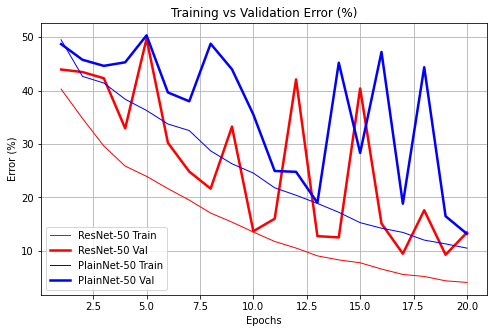

In [ ]:
plt.figure(figsize=(8, 5))
plot_dual_error(history_resnet50, label='ResNet-50', color='red')
plot_dual_error(history_plain50, label='PlainNet-50', color='blue')
plt.xlabel('Epochs')
plt.ylabel('Error (%)')
plt.title('Training vs Validation Error (%)')
plt.legend()
plt.grid(True)
plt.show()


In [ ]:
# ResNet-50 계속 학습 (Epoch 21~50)
history_resnet50_continue2 = resnet_50.fit(
    ds_train,
    validation_data=ds_val,
    epochs=50,
    initial_epoch=20
)

# PlainNet-50 계속 학습 (Epoch 21~50)
history_plain50_continue2 = plainnet_50.fit(
    ds_train,
    validation_data=ds_val,
    epochs=50,
    initial_epoch=20
)


Epoch 21/50
192/582 [========>.....................] - ETA: 2:30 - loss: 0.1066 - accuracy: 0.9580

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


229/582 [==========>...................] - ETA: 2:16 - loss: 0.1083 - accuracy: 0.9566

241/582 [===========>..................] - ETA: 2:11 - loss: 0.1086 - accuracy: 0.9567

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


285/582 [=============>................] - ETA: 1:54 - loss: 0.1097 - accuracy: 0.9559

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9


333/582 [================>.............] - ETA: 1:36 - loss: 0.1071 - accuracy: 0.9566

Corrupt JPEG data: 252 extraneous bytes before marker 0xd9


334/582 [================>.............] - ETA: 1:35 - loss: 0.1069 - accuracy: 0.9567

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


350/582 [=================>............] - ETA: 1:29 - loss: 0.1078 - accuracy: 0.9563

Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


510/582 [=========================>....] - ETA: 27s - loss: 0.1020 - accuracy: 0.9595

Corrupt JPEG data: 214 extraneous bytes before marker 0xd9


582/582 [==============================] - ETA: 0s - loss: 0.0992 - accuracy: 0.9607

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9
Corrupt JPEG data: 396 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 65 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9
Corrupt JPEG data: 128 extraneous bytes before marker 0xd9
Corrupt JPEG data: 239 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9
Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


582/582 [==============================] - 247s 423ms/step - loss: 0.0992 - accuracy: 0.9607 - val_loss: 0.5234 - val_accuracy: 0.8382
Epoch 22/50
192/582 [========>.....................] - ETA: 2:30 - loss: 0.0890 - accuracy: 0.9645

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


229/582 [==========>...................] - ETA: 2:16 - loss: 0.0904 - accuracy: 0.9641

241/582 [===========>..................] - ETA: 2:11 - loss: 0.0920 - accuracy: 0.9637

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


285/582 [=============>................] - ETA: 1:54 - loss: 0.0936 - accuracy: 0.9632

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9


333/582 [================>.............] - ETA: 1:36 - loss: 0.0932 - accuracy: 0.9631

Corrupt JPEG data: 252 extraneous bytes before marker 0xd9


334/582 [================>.............] - ETA: 1:35 - loss: 0.0931 - accuracy: 0.9632

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


350/582 [=================>............] - ETA: 1:29 - loss: 0.0919 - accuracy: 0.9638

Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


510/582 [=========================>....] - ETA: 27s - loss: 0.0884 - accuracy: 0.9654

Corrupt JPEG data: 214 extraneous bytes before marker 0xd9


582/582 [==============================] - ETA: 0s - loss: 0.0903 - accuracy: 0.9653

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9
Corrupt JPEG data: 396 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 65 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9
Corrupt JPEG data: 128 extraneous bytes before marker 0xd9
Corrupt JPEG data: 239 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9
Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


582/582 [==============================] - 247s 423ms/step - loss: 0.0903 - accuracy: 0.9653 - val_loss: 0.6444 - val_accuracy: 0.8549
Epoch 23/50
192/582 [========>.....................] - ETA: 2:30 - loss: 0.0664 - accuracy: 0.9744

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


229/582 [==========>...................] - ETA: 2:16 - loss: 0.0725 - accuracy: 0.9718

241/582 [===========>..................] - ETA: 2:11 - loss: 0.0732 - accuracy: 0.9716

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


285/582 [=============>................] - ETA: 1:54 - loss: 0.0787 - accuracy: 0.9689

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9


333/582 [================>.............] - ETA: 1:36 - loss: 0.0796 - accuracy: 0.9686

Corrupt JPEG data: 252 extraneous bytes before marker 0xd9


334/582 [================>.............] - ETA: 1:35 - loss: 0.0795 - accuracy: 0.9687

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


350/582 [=================>............] - ETA: 1:29 - loss: 0.0787 - accuracy: 0.9688

Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


510/582 [=========================>....] - ETA: 27s - loss: 0.0745 - accuracy: 0.9708

Corrupt JPEG data: 214 extraneous bytes before marker 0xd9


582/582 [==============================] - ETA: 0s - loss: 0.0720 - accuracy: 0.9715

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9
Corrupt JPEG data: 396 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 65 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9
Corrupt JPEG data: 128 extraneous bytes before marker 0xd9
Corrupt JPEG data: 239 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9
Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


582/582 [==============================] - 247s 423ms/step - loss: 0.0720 - accuracy: 0.9715 - val_loss: 0.2885 - val_accuracy: 0.9037
Epoch 24/50
192/582 [========>.....................] - ETA: 2:30 - loss: 0.0752 - accuracy: 0.9712

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


229/582 [==========>...................] - ETA: 2:16 - loss: 0.0727 - accuracy: 0.9719

241/582 [===========>..................] - ETA: 2:11 - loss: 0.0732 - accuracy: 0.9720

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


285/582 [=============>................] - ETA: 1:54 - loss: 0.0774 - accuracy: 0.9703

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9


333/582 [================>.............] - ETA: 1:35 - loss: 0.0782 - accuracy: 0.9709

Corrupt JPEG data: 252 extraneous bytes before marker 0xd9


334/582 [================>.............] - ETA: 1:35 - loss: 0.0784 - accuracy: 0.9708

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


350/582 [=================>............] - ETA: 1:29 - loss: 0.0775 - accuracy: 0.9710

Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


510/582 [=========================>....] - ETA: 27s - loss: 0.0711 - accuracy: 0.9732

Corrupt JPEG data: 214 extraneous bytes before marker 0xd9


582/582 [==============================] - ETA: 0s - loss: 0.0699 - accuracy: 0.9733

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9
Corrupt JPEG data: 396 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 65 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9
Corrupt JPEG data: 128 extraneous bytes before marker 0xd9
Corrupt JPEG data: 239 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9
Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


582/582 [==============================] - 247s 423ms/step - loss: 0.0699 - accuracy: 0.9733 - val_loss: 0.5090 - val_accuracy: 0.8481
Epoch 25/50
192/582 [========>.....................] - ETA: 2:30 - loss: 0.0673 - accuracy: 0.9730

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


229/582 [==========>...................] - ETA: 2:16 - loss: 0.0688 - accuracy: 0.9727

241/582 [===========>..................] - ETA: 2:11 - loss: 0.0688 - accuracy: 0.9724

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


285/582 [=============>................] - ETA: 1:54 - loss: 0.0685 - accuracy: 0.9728

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9


333/582 [================>.............] - ETA: 1:36 - loss: 0.0665 - accuracy: 0.9734

Corrupt JPEG data: 252 extraneous bytes before marker 0xd9


334/582 [================>.............] - ETA: 1:35 - loss: 0.0667 - accuracy: 0.9733

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


350/582 [=================>............] - ETA: 1:29 - loss: 0.0674 - accuracy: 0.9730

Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


510/582 [=========================>....] - ETA: 27s - loss: 0.0655 - accuracy: 0.9743

Corrupt JPEG data: 214 extraneous bytes before marker 0xd9


582/582 [==============================] - ETA: 0s - loss: 0.0651 - accuracy: 0.9745

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9
Corrupt JPEG data: 396 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 65 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9
Corrupt JPEG data: 128 extraneous bytes before marker 0xd9
Corrupt JPEG data: 239 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9
Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


582/582 [==============================] - 247s 422ms/step - loss: 0.0651 - accuracy: 0.9745 - val_loss: 0.2886 - val_accuracy: 0.9132
Epoch 26/50
192/582 [========>.....................] - ETA: 2:30 - loss: 0.0602 - accuracy: 0.9798

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


229/582 [==========>...................] - ETA: 2:16 - loss: 0.0612 - accuracy: 0.9797

241/582 [===========>..................] - ETA: 2:11 - loss: 0.0603 - accuracy: 0.9798

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


285/582 [=============>................] - ETA: 1:54 - loss: 0.0578 - accuracy: 0.9805

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9


333/582 [================>.............] - ETA: 1:36 - loss: 0.0598 - accuracy: 0.9794

Corrupt JPEG data: 252 extraneous bytes before marker 0xd9


334/582 [================>.............] - ETA: 1:35 - loss: 0.0606 - accuracy: 0.9791

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


350/582 [=================>............] - ETA: 1:29 - loss: 0.0622 - accuracy: 0.9785

Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


510/582 [=========================>....] - ETA: 27s - loss: 0.0639 - accuracy: 0.9771

Corrupt JPEG data: 214 extraneous bytes before marker 0xd9


582/582 [==============================] - ETA: 0s - loss: 0.0624 - accuracy: 0.9775

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9
Corrupt JPEG data: 396 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 65 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9
Corrupt JPEG data: 128 extraneous bytes before marker 0xd9
Corrupt JPEG data: 239 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9
Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


582/582 [==============================] - 247s 423ms/step - loss: 0.0624 - accuracy: 0.9775 - val_loss: 0.3438 - val_accuracy: 0.8859
Epoch 27/50
192/582 [========>.....................] - ETA: 2:30 - loss: 0.0456 - accuracy: 0.9829

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


229/582 [==========>...................] - ETA: 2:16 - loss: 0.0444 - accuracy: 0.9835

241/582 [===========>..................] - ETA: 2:11 - loss: 0.0437 - accuracy: 0.9839

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


285/582 [=============>................] - ETA: 1:54 - loss: 0.0420 - accuracy: 0.9845

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9


333/582 [================>.............] - ETA: 1:36 - loss: 0.0444 - accuracy: 0.9834

Corrupt JPEG data: 252 extraneous bytes before marker 0xd9


334/582 [================>.............] - ETA: 1:35 - loss: 0.0448 - accuracy: 0.9833

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


350/582 [=================>............] - ETA: 1:29 - loss: 0.0448 - accuracy: 0.9834

Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


510/582 [=========================>....] - ETA: 27s - loss: 0.0456 - accuracy: 0.9833

Corrupt JPEG data: 214 extraneous bytes before marker 0xd9


582/582 [==============================] - ETA: 0s - loss: 0.0460 - accuracy: 0.9831

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9
Corrupt JPEG data: 396 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 65 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9
Corrupt JPEG data: 128 extraneous bytes before marker 0xd9
Corrupt JPEG data: 239 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9
Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


582/582 [==============================] - 247s 422ms/step - loss: 0.0460 - accuracy: 0.9831 - val_loss: 0.2876 - val_accuracy: 0.9031
Epoch 28/50
192/582 [========>.....................] - ETA: 2:30 - loss: 0.0825 - accuracy: 0.9718

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


229/582 [==========>...................] - ETA: 2:16 - loss: 0.0837 - accuracy: 0.9708

241/582 [===========>..................] - ETA: 2:11 - loss: 0.0826 - accuracy: 0.9710

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


285/582 [=============>................] - ETA: 1:54 - loss: 0.0799 - accuracy: 0.9717

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9


333/582 [================>.............] - ETA: 1:35 - loss: 0.0755 - accuracy: 0.9727

Corrupt JPEG data: 252 extraneous bytes before marker 0xd9


334/582 [================>.............] - ETA: 1:35 - loss: 0.0756 - accuracy: 0.9726

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


350/582 [=================>............] - ETA: 1:29 - loss: 0.0736 - accuracy: 0.9733

Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


510/582 [=========================>....] - ETA: 27s - loss: 0.0675 - accuracy: 0.9749

Corrupt JPEG data: 214 extraneous bytes before marker 0xd9


582/582 [==============================] - ETA: 0s - loss: 0.0648 - accuracy: 0.9757

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9
Corrupt JPEG data: 396 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 65 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9
Corrupt JPEG data: 128 extraneous bytes before marker 0xd9
Corrupt JPEG data: 239 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9
Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


582/582 [==============================] - 247s 423ms/step - loss: 0.0648 - accuracy: 0.9757 - val_loss: 0.2662 - val_accuracy: 0.9220
Epoch 29/50
192/582 [========>.....................] - ETA: 2:30 - loss: 0.0472 - accuracy: 0.9834

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


229/582 [==========>...................] - ETA: 2:16 - loss: 0.0466 - accuracy: 0.9829

241/582 [===========>..................] - ETA: 2:11 - loss: 0.0466 - accuracy: 0.9829

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


285/582 [=============>................] - ETA: 1:54 - loss: 0.0459 - accuracy: 0.9833

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9


333/582 [================>.............] - ETA: 1:36 - loss: 0.0463 - accuracy: 0.9833

Corrupt JPEG data: 252 extraneous bytes before marker 0xd9


334/582 [================>.............] - ETA: 1:35 - loss: 0.0463 - accuracy: 0.9833

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


350/582 [=================>............] - ETA: 1:29 - loss: 0.0456 - accuracy: 0.9836

Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


510/582 [=========================>....] - ETA: 27s - loss: 0.0452 - accuracy: 0.9836

Corrupt JPEG data: 214 extraneous bytes before marker 0xd9


582/582 [==============================] - ETA: 0s - loss: 0.0419 - accuracy: 0.9850

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9
Corrupt JPEG data: 396 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 65 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9
Corrupt JPEG data: 128 extraneous bytes before marker 0xd9
Corrupt JPEG data: 239 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9
Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


582/582 [==============================] - 247s 423ms/step - loss: 0.0419 - accuracy: 0.9850 - val_loss: 0.3927 - val_accuracy: 0.8829
Epoch 30/50
192/582 [========>.....................] - ETA: 2:30 - loss: 0.0439 - accuracy: 0.9837

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


229/582 [==========>...................] - ETA: 2:16 - loss: 0.0444 - accuracy: 0.9832

241/582 [===========>..................] - ETA: 2:11 - loss: 0.0442 - accuracy: 0.9833

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


285/582 [=============>................] - ETA: 1:54 - loss: 0.0448 - accuracy: 0.9832

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9


333/582 [================>.............] - ETA: 1:35 - loss: 0.0426 - accuracy: 0.9840

Corrupt JPEG data: 252 extraneous bytes before marker 0xd9


334/582 [================>.............] - ETA: 1:35 - loss: 0.0427 - accuracy: 0.9840

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


350/582 [=================>............] - ETA: 1:29 - loss: 0.0426 - accuracy: 0.9841

Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


510/582 [=========================>....] - ETA: 27s - loss: 0.0445 - accuracy: 0.9835

Corrupt JPEG data: 214 extraneous bytes before marker 0xd9


582/582 [==============================] - ETA: 0s - loss: 0.0470 - accuracy: 0.9832

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9
Corrupt JPEG data: 396 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 65 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9
Corrupt JPEG data: 128 extraneous bytes before marker 0xd9
Corrupt JPEG data: 239 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9
Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


582/582 [==============================] - 247s 422ms/step - loss: 0.0470 - accuracy: 0.9832 - val_loss: 0.3137 - val_accuracy: 0.8971
Epoch 31/50
192/582 [========>.....................] - ETA: 2:30 - loss: 0.0491 - accuracy: 0.9831

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


229/582 [==========>...................] - ETA: 2:15 - loss: 0.0475 - accuracy: 0.9839

241/582 [===========>..................] - ETA: 2:11 - loss: 0.0460 - accuracy: 0.9846

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


285/582 [=============>................] - ETA: 1:54 - loss: 0.0451 - accuracy: 0.9849

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9


333/582 [================>.............] - ETA: 1:35 - loss: 0.0442 - accuracy: 0.9850

Corrupt JPEG data: 252 extraneous bytes before marker 0xd9


334/582 [================>.............] - ETA: 1:35 - loss: 0.0441 - accuracy: 0.9850

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


350/582 [=================>............] - ETA: 1:29 - loss: 0.0445 - accuracy: 0.9847

Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


510/582 [=========================>....] - ETA: 27s - loss: 0.0433 - accuracy: 0.9850

Corrupt JPEG data: 214 extraneous bytes before marker 0xd9


582/582 [==============================] - ETA: 0s - loss: 0.0419 - accuracy: 0.9854

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9
Corrupt JPEG data: 396 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 65 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9
Corrupt JPEG data: 128 extraneous bytes before marker 0xd9
Corrupt JPEG data: 239 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9
Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


582/582 [==============================] - 247s 423ms/step - loss: 0.0419 - accuracy: 0.9854 - val_loss: 0.2761 - val_accuracy: 0.9181
Epoch 32/50
192/582 [========>.....................] - ETA: 2:30 - loss: 0.0292 - accuracy: 0.9899

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


229/582 [==========>...................] - ETA: 2:15 - loss: 0.0273 - accuracy: 0.9909

241/582 [===========>..................] - ETA: 2:11 - loss: 0.0277 - accuracy: 0.9908

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


285/582 [=============>................] - ETA: 1:54 - loss: 0.0275 - accuracy: 0.9908

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9


333/582 [================>.............] - ETA: 1:35 - loss: 0.0259 - accuracy: 0.9914

Corrupt JPEG data: 252 extraneous bytes before marker 0xd9


334/582 [================>.............] - ETA: 1:35 - loss: 0.0259 - accuracy: 0.9914

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


350/582 [=================>............] - ETA: 1:29 - loss: 0.0256 - accuracy: 0.9915

Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


510/582 [=========================>....] - ETA: 27s - loss: 0.0264 - accuracy: 0.9909

Corrupt JPEG data: 214 extraneous bytes before marker 0xd9


582/582 [==============================] - ETA: 0s - loss: 0.0285 - accuracy: 0.9900

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9
Corrupt JPEG data: 396 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 65 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9
Corrupt JPEG data: 128 extraneous bytes before marker 0xd9
Corrupt JPEG data: 239 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9
Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


582/582 [==============================] - 246s 422ms/step - loss: 0.0285 - accuracy: 0.9900 - val_loss: 0.5079 - val_accuracy: 0.8708
Epoch 33/50
192/582 [========>.....................] - ETA: 2:30 - loss: 0.0454 - accuracy: 0.9840

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


229/582 [==========>...................] - ETA: 2:15 - loss: 0.0497 - accuracy: 0.9832

241/582 [===========>..................] - ETA: 2:11 - loss: 0.0492 - accuracy: 0.9830

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


285/582 [=============>................] - ETA: 1:54 - loss: 0.0473 - accuracy: 0.9831

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9


333/582 [================>.............] - ETA: 1:35 - loss: 0.0467 - accuracy: 0.9832

Corrupt JPEG data: 252 extraneous bytes before marker 0xd9


334/582 [================>.............] - ETA: 1:35 - loss: 0.0466 - accuracy: 0.9833

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


350/582 [=================>............] - ETA: 1:29 - loss: 0.0461 - accuracy: 0.9835

Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


510/582 [=========================>....] - ETA: 27s - loss: 0.0424 - accuracy: 0.9849

Corrupt JPEG data: 214 extraneous bytes before marker 0xd9


582/582 [==============================] - ETA: 0s - loss: 0.0445 - accuracy: 0.9842

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9
Corrupt JPEG data: 396 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 65 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9
Corrupt JPEG data: 128 extraneous bytes before marker 0xd9
Corrupt JPEG data: 239 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9
Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


582/582 [==============================] - 246s 422ms/step - loss: 0.0445 - accuracy: 0.9842 - val_loss: 0.4660 - val_accuracy: 0.8676
Epoch 34/50
192/582 [========>.....................] - ETA: 2:30 - loss: 0.0316 - accuracy: 0.9878

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


229/582 [==========>...................] - ETA: 2:15 - loss: 0.0361 - accuracy: 0.9865

241/582 [===========>..................] - ETA: 2:11 - loss: 0.0373 - accuracy: 0.9861

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


285/582 [=============>................] - ETA: 1:54 - loss: 0.0392 - accuracy: 0.9860

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9


333/582 [================>.............] - ETA: 1:35 - loss: 0.0410 - accuracy: 0.9849

Corrupt JPEG data: 252 extraneous bytes before marker 0xd9


334/582 [================>.............] - ETA: 1:35 - loss: 0.0413 - accuracy: 0.9848

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


350/582 [=================>............] - ETA: 1:29 - loss: 0.0409 - accuracy: 0.9852

Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


510/582 [=========================>....] - ETA: 27s - loss: 0.0392 - accuracy: 0.9857

Corrupt JPEG data: 214 extraneous bytes before marker 0xd9


582/582 [==============================] - ETA: 0s - loss: 0.0379 - accuracy: 0.9866

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9
Corrupt JPEG data: 396 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 65 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9
Corrupt JPEG data: 128 extraneous bytes before marker 0xd9
Corrupt JPEG data: 239 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9
Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


582/582 [==============================] - 247s 422ms/step - loss: 0.0379 - accuracy: 0.9866 - val_loss: 0.3038 - val_accuracy: 0.9181
Epoch 35/50
192/582 [========>.....................] - ETA: 2:30 - loss: 0.0244 - accuracy: 0.9922

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


229/582 [==========>...................] - ETA: 2:15 - loss: 0.0252 - accuracy: 0.9921

241/582 [===========>..................] - ETA: 2:11 - loss: 0.0257 - accuracy: 0.9918

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


285/582 [=============>................] - ETA: 1:54 - loss: 0.0245 - accuracy: 0.9920

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9


333/582 [================>.............] - ETA: 1:35 - loss: 0.0228 - accuracy: 0.9926

Corrupt JPEG data: 252 extraneous bytes before marker 0xd9


334/582 [================>.............] - ETA: 1:35 - loss: 0.0228 - accuracy: 0.9926

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


350/582 [=================>............] - ETA: 1:29 - loss: 0.0230 - accuracy: 0.9928

Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


510/582 [=========================>....] - ETA: 27s - loss: 0.0247 - accuracy: 0.9915

Corrupt JPEG data: 214 extraneous bytes before marker 0xd9


582/582 [==============================] - ETA: 0s - loss: 0.0248 - accuracy: 0.9915

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9
Corrupt JPEG data: 396 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 65 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9
Corrupt JPEG data: 128 extraneous bytes before marker 0xd9
Corrupt JPEG data: 239 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9
Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


582/582 [==============================] - 246s 422ms/step - loss: 0.0248 - accuracy: 0.9915 - val_loss: 0.7478 - val_accuracy: 0.8579
Epoch 36/50
192/582 [========>.....................] - ETA: 2:30 - loss: 0.0426 - accuracy: 0.9845

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


229/582 [==========>...................] - ETA: 2:15 - loss: 0.0398 - accuracy: 0.9853

241/582 [===========>..................] - ETA: 2:11 - loss: 0.0394 - accuracy: 0.9853

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


285/582 [=============>................] - ETA: 1:54 - loss: 0.0383 - accuracy: 0.9864

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9


333/582 [================>.............] - ETA: 1:35 - loss: 0.0370 - accuracy: 0.9870

Corrupt JPEG data: 252 extraneous bytes before marker 0xd9


334/582 [================>.............] - ETA: 1:35 - loss: 0.0372 - accuracy: 0.9870

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


350/582 [=================>............] - ETA: 1:29 - loss: 0.0367 - accuracy: 0.9871

Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


510/582 [=========================>....] - ETA: 27s - loss: 0.0349 - accuracy: 0.9879

Corrupt JPEG data: 214 extraneous bytes before marker 0xd9


582/582 [==============================] - ETA: 0s - loss: 0.0370 - accuracy: 0.9878

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9
Corrupt JPEG data: 396 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 65 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9
Corrupt JPEG data: 128 extraneous bytes before marker 0xd9
Corrupt JPEG data: 239 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9
Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


582/582 [==============================] - 247s 422ms/step - loss: 0.0370 - accuracy: 0.9878 - val_loss: 0.4961 - val_accuracy: 0.8855
Epoch 37/50
192/582 [========>.....................] - ETA: 2:30 - loss: 0.0279 - accuracy: 0.9917

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


229/582 [==========>...................] - ETA: 2:16 - loss: 0.0288 - accuracy: 0.9917

241/582 [===========>..................] - ETA: 2:11 - loss: 0.0285 - accuracy: 0.9917

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


285/582 [=============>................] - ETA: 1:54 - loss: 0.0282 - accuracy: 0.9918

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9


333/582 [================>.............] - ETA: 1:36 - loss: 0.0299 - accuracy: 0.9911

Corrupt JPEG data: 252 extraneous bytes before marker 0xd9


334/582 [================>.............] - ETA: 1:35 - loss: 0.0298 - accuracy: 0.9911

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


350/582 [=================>............] - ETA: 1:29 - loss: 0.0335 - accuracy: 0.9899

Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


510/582 [=========================>....] - ETA: 27s - loss: 0.0407 - accuracy: 0.9869

Corrupt JPEG data: 214 extraneous bytes before marker 0xd9


582/582 [==============================] - ETA: 0s - loss: 0.0388 - accuracy: 0.9873

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9
Corrupt JPEG data: 396 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 65 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9
Corrupt JPEG data: 128 extraneous bytes before marker 0xd9
Corrupt JPEG data: 239 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9
Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


582/582 [==============================] - 246s 422ms/step - loss: 0.0388 - accuracy: 0.9873 - val_loss: 0.2826 - val_accuracy: 0.9147
Epoch 38/50
192/582 [========>.....................] - ETA: 2:30 - loss: 0.0234 - accuracy: 0.9917

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


229/582 [==========>...................] - ETA: 2:15 - loss: 0.0227 - accuracy: 0.9919

241/582 [===========>..................] - ETA: 2:11 - loss: 0.0220 - accuracy: 0.9922

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


285/582 [=============>................] - ETA: 1:54 - loss: 0.0209 - accuracy: 0.9924

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9


333/582 [================>.............] - ETA: 1:35 - loss: 0.0223 - accuracy: 0.9917

Corrupt JPEG data: 252 extraneous bytes before marker 0xd9


334/582 [================>.............] - ETA: 1:35 - loss: 0.0222 - accuracy: 0.9918

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


350/582 [=================>............] - ETA: 1:29 - loss: 0.0219 - accuracy: 0.9919

Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


510/582 [=========================>....] - ETA: 27s - loss: 0.0217 - accuracy: 0.9925

Corrupt JPEG data: 214 extraneous bytes before marker 0xd9


582/582 [==============================] - ETA: 0s - loss: 0.0220 - accuracy: 0.9925

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9
Corrupt JPEG data: 396 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 65 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9
Corrupt JPEG data: 128 extraneous bytes before marker 0xd9
Corrupt JPEG data: 239 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9
Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


582/582 [==============================] - 246s 422ms/step - loss: 0.0220 - accuracy: 0.9925 - val_loss: 0.3069 - val_accuracy: 0.9140
Epoch 39/50
192/582 [========>.....................] - ETA: 2:30 - loss: 0.0260 - accuracy: 0.9904

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


229/582 [==========>...................] - ETA: 2:16 - loss: 0.0331 - accuracy: 0.9876

241/582 [===========>..................] - ETA: 2:11 - loss: 0.0343 - accuracy: 0.9870

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


285/582 [=============>................] - ETA: 1:54 - loss: 0.0383 - accuracy: 0.9861

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9


333/582 [================>.............] - ETA: 1:36 - loss: 0.0380 - accuracy: 0.9860

Corrupt JPEG data: 252 extraneous bytes before marker 0xd9


334/582 [================>.............] - ETA: 1:35 - loss: 0.0379 - accuracy: 0.9861

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


350/582 [=================>............] - ETA: 1:29 - loss: 0.0369 - accuracy: 0.9865

Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


510/582 [=========================>....] - ETA: 27s - loss: 0.0342 - accuracy: 0.9878

Corrupt JPEG data: 214 extraneous bytes before marker 0xd9


582/582 [==============================] - ETA: 0s - loss: 0.0337 - accuracy: 0.9880

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9
Corrupt JPEG data: 396 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 65 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9
Corrupt JPEG data: 128 extraneous bytes before marker 0xd9
Corrupt JPEG data: 239 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9
Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


582/582 [==============================] - 247s 422ms/step - loss: 0.0337 - accuracy: 0.9880 - val_loss: 0.7610 - val_accuracy: 0.8317
Epoch 40/50
192/582 [========>.....................] - ETA: 2:30 - loss: 0.0244 - accuracy: 0.9912

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


229/582 [==========>...................] - ETA: 2:15 - loss: 0.0241 - accuracy: 0.9913

241/582 [===========>..................] - ETA: 2:11 - loss: 0.0241 - accuracy: 0.9914

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


285/582 [=============>................] - ETA: 1:54 - loss: 0.0256 - accuracy: 0.9910

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9


333/582 [================>.............] - ETA: 1:35 - loss: 0.0235 - accuracy: 0.9916

Corrupt JPEG data: 252 extraneous bytes before marker 0xd9


334/582 [================>.............] - ETA: 1:35 - loss: 0.0235 - accuracy: 0.9917

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


350/582 [=================>............] - ETA: 1:29 - loss: 0.0231 - accuracy: 0.9917

Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


510/582 [=========================>....] - ETA: 27s - loss: 0.0250 - accuracy: 0.9912

Corrupt JPEG data: 214 extraneous bytes before marker 0xd9


582/582 [==============================] - ETA: 0s - loss: 0.0251 - accuracy: 0.9909

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9
Corrupt JPEG data: 396 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 65 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9
Corrupt JPEG data: 128 extraneous bytes before marker 0xd9
Corrupt JPEG data: 239 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9
Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


582/582 [==============================] - 247s 423ms/step - loss: 0.0251 - accuracy: 0.9909 - val_loss: 0.3640 - val_accuracy: 0.9160
Epoch 41/50
192/582 [========>.....................] - ETA: 2:30 - loss: 0.0317 - accuracy: 0.9886

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


229/582 [==========>...................] - ETA: 2:16 - loss: 0.0293 - accuracy: 0.9895

241/582 [===========>..................] - ETA: 2:11 - loss: 0.0293 - accuracy: 0.9895

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


285/582 [=============>................] - ETA: 1:54 - loss: 0.0261 - accuracy: 0.9907

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9


333/582 [================>.............] - ETA: 1:35 - loss: 0.0252 - accuracy: 0.9908

Corrupt JPEG data: 252 extraneous bytes before marker 0xd9


334/582 [================>.............] - ETA: 1:35 - loss: 0.0252 - accuracy: 0.9908

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


350/582 [=================>............] - ETA: 1:29 - loss: 0.0247 - accuracy: 0.9911

Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


510/582 [=========================>....] - ETA: 27s - loss: 0.0275 - accuracy: 0.9899

Corrupt JPEG data: 214 extraneous bytes before marker 0xd9


582/582 [==============================] - ETA: 0s - loss: 0.0279 - accuracy: 0.9898

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9
Corrupt JPEG data: 396 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 65 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9
Corrupt JPEG data: 128 extraneous bytes before marker 0xd9
Corrupt JPEG data: 239 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9
Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


582/582 [==============================] - 247s 423ms/step - loss: 0.0279 - accuracy: 0.9898 - val_loss: 0.3280 - val_accuracy: 0.9160
Epoch 42/50
192/582 [========>.....................] - ETA: 2:30 - loss: 0.0263 - accuracy: 0.9920

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


229/582 [==========>...................] - ETA: 2:15 - loss: 0.0258 - accuracy: 0.9921

241/582 [===========>..................] - ETA: 2:11 - loss: 0.0258 - accuracy: 0.9918

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


285/582 [=============>................] - ETA: 1:54 - loss: 0.0267 - accuracy: 0.9913

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9


333/582 [================>.............] - ETA: 1:35 - loss: 0.0267 - accuracy: 0.9913

Corrupt JPEG data: 252 extraneous bytes before marker 0xd9


334/582 [================>.............] - ETA: 1:35 - loss: 0.0266 - accuracy: 0.9913

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


350/582 [=================>............] - ETA: 1:29 - loss: 0.0262 - accuracy: 0.9913

Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


510/582 [=========================>....] - ETA: 27s - loss: 0.0229 - accuracy: 0.9921

Corrupt JPEG data: 214 extraneous bytes before marker 0xd9


582/582 [==============================] - ETA: 0s - loss: 0.0248 - accuracy: 0.9916

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9
Corrupt JPEG data: 396 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 65 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9
Corrupt JPEG data: 128 extraneous bytes before marker 0xd9
Corrupt JPEG data: 239 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9
Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


582/582 [==============================] - 247s 422ms/step - loss: 0.0248 - accuracy: 0.9916 - val_loss: 0.2875 - val_accuracy: 0.9278
Epoch 43/50
192/582 [========>.....................] - ETA: 2:30 - loss: 0.0292 - accuracy: 0.9894

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


229/582 [==========>...................] - ETA: 2:16 - loss: 0.0294 - accuracy: 0.9894

241/582 [===========>..................] - ETA: 2:11 - loss: 0.0293 - accuracy: 0.9895

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


285/582 [=============>................] - ETA: 1:54 - loss: 0.0279 - accuracy: 0.9900

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9


333/582 [================>.............] - ETA: 1:35 - loss: 0.0292 - accuracy: 0.9895

Corrupt JPEG data: 252 extraneous bytes before marker 0xd9


334/582 [================>.............] - ETA: 1:35 - loss: 0.0291 - accuracy: 0.9895

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


350/582 [=================>............] - ETA: 1:29 - loss: 0.0297 - accuracy: 0.9895

Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


510/582 [=========================>....] - ETA: 27s - loss: 0.0260 - accuracy: 0.9907

Corrupt JPEG data: 214 extraneous bytes before marker 0xd9


582/582 [==============================] - ETA: 0s - loss: 0.0265 - accuracy: 0.9905

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9
Corrupt JPEG data: 396 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 65 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9
Corrupt JPEG data: 128 extraneous bytes before marker 0xd9
Corrupt JPEG data: 239 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9
Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


582/582 [==============================] - 247s 422ms/step - loss: 0.0265 - accuracy: 0.9905 - val_loss: 0.3232 - val_accuracy: 0.9112
Epoch 44/50
192/582 [========>.....................] - ETA: 2:30 - loss: 0.0278 - accuracy: 0.9906

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


229/582 [==========>...................] - ETA: 2:15 - loss: 0.0266 - accuracy: 0.9907

241/582 [===========>..................] - ETA: 2:11 - loss: 0.0266 - accuracy: 0.9908

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


285/582 [=============>................] - ETA: 1:54 - loss: 0.0267 - accuracy: 0.9904

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9


333/582 [================>.............] - ETA: 1:35 - loss: 0.0262 - accuracy: 0.9904

Corrupt JPEG data: 252 extraneous bytes before marker 0xd9


334/582 [================>.............] - ETA: 1:35 - loss: 0.0262 - accuracy: 0.9904

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


350/582 [=================>............] - ETA: 1:29 - loss: 0.0259 - accuracy: 0.9905

Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


510/582 [=========================>....] - ETA: 27s - loss: 0.0278 - accuracy: 0.9897

Corrupt JPEG data: 214 extraneous bytes before marker 0xd9


582/582 [==============================] - ETA: 0s - loss: 0.0270 - accuracy: 0.9899

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9
Corrupt JPEG data: 396 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 65 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9
Corrupt JPEG data: 128 extraneous bytes before marker 0xd9
Corrupt JPEG data: 239 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9
Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


582/582 [==============================] - 246s 422ms/step - loss: 0.0270 - accuracy: 0.9899 - val_loss: 0.4954 - val_accuracy: 0.8964
Epoch 45/50
192/582 [========>.....................] - ETA: 2:30 - loss: 0.0121 - accuracy: 0.9959

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


229/582 [==========>...................] - ETA: 2:15 - loss: 0.0127 - accuracy: 0.9962

241/582 [===========>..................] - ETA: 2:11 - loss: 0.0123 - accuracy: 0.9964

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


285/582 [=============>................] - ETA: 1:54 - loss: 0.0142 - accuracy: 0.9955

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9


333/582 [================>.............] - ETA: 1:35 - loss: 0.0152 - accuracy: 0.9951

Corrupt JPEG data: 252 extraneous bytes before marker 0xd9


334/582 [================>.............] - ETA: 1:35 - loss: 0.0153 - accuracy: 0.9950

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


350/582 [=================>............] - ETA: 1:29 - loss: 0.0162 - accuracy: 0.9946

Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


510/582 [=========================>....] - ETA: 27s - loss: 0.0159 - accuracy: 0.9947

Corrupt JPEG data: 214 extraneous bytes before marker 0xd9


582/582 [==============================] - ETA: 0s - loss: 0.0161 - accuracy: 0.9946

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9
Corrupt JPEG data: 396 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 65 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9
Corrupt JPEG data: 128 extraneous bytes before marker 0xd9
Corrupt JPEG data: 239 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9
Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


582/582 [==============================] - 246s 422ms/step - loss: 0.0161 - accuracy: 0.9946 - val_loss: 0.2815 - val_accuracy: 0.9310
Epoch 46/50
192/582 [========>.....................] - ETA: 2:30 - loss: 0.0211 - accuracy: 0.9922

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


229/582 [==========>...................] - ETA: 2:16 - loss: 0.0188 - accuracy: 0.9932

241/582 [===========>..................] - ETA: 2:11 - loss: 0.0183 - accuracy: 0.9933

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


285/582 [=============>................] - ETA: 1:54 - loss: 0.0172 - accuracy: 0.9939

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9


333/582 [================>.............] - ETA: 1:35 - loss: 0.0162 - accuracy: 0.9944

Corrupt JPEG data: 252 extraneous bytes before marker 0xd9


334/582 [================>.............] - ETA: 1:35 - loss: 0.0162 - accuracy: 0.9943

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


350/582 [=================>............] - ETA: 1:29 - loss: 0.0158 - accuracy: 0.9945

Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


510/582 [=========================>....] - ETA: 27s - loss: 0.0147 - accuracy: 0.9949

Corrupt JPEG data: 214 extraneous bytes before marker 0xd9


582/582 [==============================] - ETA: 0s - loss: 0.0143 - accuracy: 0.9952

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9
Corrupt JPEG data: 396 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 65 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9
Corrupt JPEG data: 128 extraneous bytes before marker 0xd9
Corrupt JPEG data: 239 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9
Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


582/582 [==============================] - 247s 422ms/step - loss: 0.0143 - accuracy: 0.9952 - val_loss: 0.3618 - val_accuracy: 0.9173
Epoch 47/50
192/582 [========>.....................] - ETA: 2:30 - loss: 0.0345 - accuracy: 0.9870

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


229/582 [==========>...................] - ETA: 2:15 - loss: 0.0323 - accuracy: 0.9879

241/582 [===========>..................] - ETA: 2:11 - loss: 0.0326 - accuracy: 0.9878

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


285/582 [=============>................] - ETA: 1:54 - loss: 0.0336 - accuracy: 0.9871

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9


333/582 [================>.............] - ETA: 1:35 - loss: 0.0340 - accuracy: 0.9866

Corrupt JPEG data: 252 extraneous bytes before marker 0xd9


334/582 [================>.............] - ETA: 1:35 - loss: 0.0339 - accuracy: 0.9866

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


350/582 [=================>............] - ETA: 1:29 - loss: 0.0336 - accuracy: 0.9868

Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


510/582 [=========================>....] - ETA: 27s - loss: 0.0313 - accuracy: 0.9881

Corrupt JPEG data: 214 extraneous bytes before marker 0xd9


582/582 [==============================] - ETA: 0s - loss: 0.0300 - accuracy: 0.9887

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9
Corrupt JPEG data: 396 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 65 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9
Corrupt JPEG data: 128 extraneous bytes before marker 0xd9
Corrupt JPEG data: 239 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9
Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


582/582 [==============================] - 246s 422ms/step - loss: 0.0300 - accuracy: 0.9887 - val_loss: 0.2750 - val_accuracy: 0.9168
Epoch 48/50
192/582 [========>.....................] - ETA: 2:29 - loss: 0.0349 - accuracy: 0.9888

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


229/582 [==========>...................] - ETA: 2:15 - loss: 0.0350 - accuracy: 0.9888

241/582 [===========>..................] - ETA: 2:11 - loss: 0.0340 - accuracy: 0.9894

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


285/582 [=============>................] - ETA: 1:54 - loss: 0.0313 - accuracy: 0.9902

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9


333/582 [================>.............] - ETA: 1:35 - loss: 0.0289 - accuracy: 0.9911

Corrupt JPEG data: 252 extraneous bytes before marker 0xd9


334/582 [================>.............] - ETA: 1:35 - loss: 0.0288 - accuracy: 0.9911

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


350/582 [=================>............] - ETA: 1:29 - loss: 0.0280 - accuracy: 0.9913

Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


510/582 [=========================>....] - ETA: 27s - loss: 0.0239 - accuracy: 0.9925

Corrupt JPEG data: 214 extraneous bytes before marker 0xd9


582/582 [==============================] - ETA: 0s - loss: 0.0224 - accuracy: 0.9929

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9
Corrupt JPEG data: 396 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 65 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9
Corrupt JPEG data: 128 extraneous bytes before marker 0xd9
Corrupt JPEG data: 239 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9
Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


582/582 [==============================] - 246s 421ms/step - loss: 0.0224 - accuracy: 0.9929 - val_loss: 0.2942 - val_accuracy: 0.9261
Epoch 49/50
192/582 [========>.....................] - ETA: 2:30 - loss: 0.0068 - accuracy: 0.9977

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


229/582 [==========>...................] - ETA: 2:15 - loss: 0.0083 - accuracy: 0.9975

241/582 [===========>..................] - ETA: 2:11 - loss: 0.0086 - accuracy: 0.9974

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


285/582 [=============>................] - ETA: 1:54 - loss: 0.0101 - accuracy: 0.9968

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9


333/582 [================>.............] - ETA: 1:35 - loss: 0.0104 - accuracy: 0.9968

Corrupt JPEG data: 252 extraneous bytes before marker 0xd9


334/582 [================>.............] - ETA: 1:35 - loss: 0.0103 - accuracy: 0.9968

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


350/582 [=================>............] - ETA: 1:29 - loss: 0.0104 - accuracy: 0.9968

Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


510/582 [=========================>....] - ETA: 27s - loss: 0.0169 - accuracy: 0.9949

Corrupt JPEG data: 214 extraneous bytes before marker 0xd9


582/582 [==============================] - ETA: 0s - loss: 0.0200 - accuracy: 0.9934

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9
Corrupt JPEG data: 396 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 65 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9
Corrupt JPEG data: 128 extraneous bytes before marker 0xd9
Corrupt JPEG data: 239 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9
Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


582/582 [==============================] - 246s 422ms/step - loss: 0.0200 - accuracy: 0.9934 - val_loss: 0.6780 - val_accuracy: 0.8910
Epoch 50/50
192/582 [========>.....................] - ETA: 2:29 - loss: 0.0188 - accuracy: 0.9943

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


229/582 [==========>...................] - ETA: 2:15 - loss: 0.0195 - accuracy: 0.9941

241/582 [===========>..................] - ETA: 2:11 - loss: 0.0192 - accuracy: 0.9942

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


285/582 [=============>................] - ETA: 1:54 - loss: 0.0191 - accuracy: 0.9941

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9


333/582 [================>.............] - ETA: 1:35 - loss: 0.0185 - accuracy: 0.9942

Corrupt JPEG data: 252 extraneous bytes before marker 0xd9


334/582 [================>.............] - ETA: 1:35 - loss: 0.0184 - accuracy: 0.9942

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


350/582 [=================>............] - ETA: 1:29 - loss: 0.0183 - accuracy: 0.9941

Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


510/582 [=========================>....] - ETA: 27s - loss: 0.0163 - accuracy: 0.9946

Corrupt JPEG data: 214 extraneous bytes before marker 0xd9


582/582 [==============================] - ETA: 0s - loss: 0.0164 - accuracy: 0.9947

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9
Corrupt JPEG data: 396 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 65 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9
Corrupt JPEG data: 128 extraneous bytes before marker 0xd9
Corrupt JPEG data: 239 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9
Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


582/582 [==============================] - 247s 423ms/step - loss: 0.0164 - accuracy: 0.9947 - val_loss: 0.2664 - val_accuracy: 0.9274
Epoch 21/50
192/582 [========>.....................] - ETA: 2:07 - loss: 0.2695 - accuracy: 0.8890

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


229/582 [==========>...................] - ETA: 1:55 - loss: 0.2600 - accuracy: 0.8921

241/582 [===========>..................] - ETA: 1:51 - loss: 0.2567 - accuracy: 0.8938

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


285/582 [=============>................] - ETA: 1:36 - loss: 0.2551 - accuracy: 0.8950

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9


333/582 [================>.............] - ETA: 1:21 - loss: 0.2516 - accuracy: 0.8952

Corrupt JPEG data: 252 extraneous bytes before marker 0xd9


334/582 [================>.............] - ETA: 1:20 - loss: 0.2515 - accuracy: 0.8952

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


350/582 [=================>............] - ETA: 1:15 - loss: 0.2503 - accuracy: 0.8953

Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


510/582 [=========================>....] - ETA: 23s - loss: 0.2474 - accuracy: 0.8960

Corrupt JPEG data: 214 extraneous bytes before marker 0xd9


582/582 [==============================] - ETA: 0s - loss: 0.2445 - accuracy: 0.8978

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9
Corrupt JPEG data: 396 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 65 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9
Corrupt JPEG data: 128 extraneous bytes before marker 0xd9
Corrupt JPEG data: 239 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9
Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


582/582 [==============================] - 210s 360ms/step - loss: 0.2445 - accuracy: 0.8978 - val_loss: 0.6423 - val_accuracy: 0.7836
Epoch 22/50
192/582 [========>.....................] - ETA: 2:07 - loss: 0.2343 - accuracy: 0.8970

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


229/582 [==========>...................] - ETA: 1:55 - loss: 0.2345 - accuracy: 0.8979

241/582 [===========>..................] - ETA: 1:51 - loss: 0.2351 - accuracy: 0.8982

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


285/582 [=============>................] - ETA: 1:36 - loss: 0.2329 - accuracy: 0.8997

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9


333/582 [================>.............] - ETA: 1:21 - loss: 0.2324 - accuracy: 0.8998

Corrupt JPEG data: 252 extraneous bytes before marker 0xd9


334/582 [================>.............] - ETA: 1:21 - loss: 0.2326 - accuracy: 0.8998

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


350/582 [=================>............] - ETA: 1:15 - loss: 0.2339 - accuracy: 0.8991

Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


510/582 [=========================>....] - ETA: 23s - loss: 0.2347 - accuracy: 0.8999

Corrupt JPEG data: 214 extraneous bytes before marker 0xd9


582/582 [==============================] - ETA: 0s - loss: 0.2302 - accuracy: 0.9027

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9
Corrupt JPEG data: 396 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 65 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9
Corrupt JPEG data: 128 extraneous bytes before marker 0xd9
Corrupt JPEG data: 239 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9
Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


582/582 [==============================] - 210s 359ms/step - loss: 0.2302 - accuracy: 0.9027 - val_loss: 0.3931 - val_accuracy: 0.8367
Epoch 23/50
192/582 [========>.....................] - ETA: 2:07 - loss: 0.2267 - accuracy: 0.9004

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


229/582 [==========>...................] - ETA: 1:55 - loss: 0.2201 - accuracy: 0.9034

241/582 [===========>..................] - ETA: 1:51 - loss: 0.2211 - accuracy: 0.9037

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


285/582 [=============>................] - ETA: 1:37 - loss: 0.2184 - accuracy: 0.9056

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9


333/582 [================>.............] - ETA: 1:21 - loss: 0.2198 - accuracy: 0.9062

Corrupt JPEG data: 252 extraneous bytes before marker 0xd9


334/582 [================>.............] - ETA: 1:21 - loss: 0.2195 - accuracy: 0.9063

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


350/582 [=================>............] - ETA: 1:15 - loss: 0.2188 - accuracy: 0.9071

Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


510/582 [=========================>....] - ETA: 23s - loss: 0.2180 - accuracy: 0.9080

Corrupt JPEG data: 214 extraneous bytes before marker 0xd9


582/582 [==============================] - ETA: 0s - loss: 0.2154 - accuracy: 0.9096

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9
Corrupt JPEG data: 396 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 65 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9
Corrupt JPEG data: 128 extraneous bytes before marker 0xd9
Corrupt JPEG data: 239 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9
Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


582/582 [==============================] - 210s 360ms/step - loss: 0.2154 - accuracy: 0.9096 - val_loss: 1.1093 - val_accuracy: 0.7043
Epoch 24/50
192/582 [========>.....................] - ETA: 2:07 - loss: 0.2102 - accuracy: 0.9090

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


229/582 [==========>...................] - ETA: 1:55 - loss: 0.2121 - accuracy: 0.9103

241/582 [===========>..................] - ETA: 1:51 - loss: 0.2120 - accuracy: 0.9105

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


285/582 [=============>................] - ETA: 1:37 - loss: 0.2149 - accuracy: 0.9101

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9


333/582 [================>.............] - ETA: 1:21 - loss: 0.2127 - accuracy: 0.9110

Corrupt JPEG data: 252 extraneous bytes before marker 0xd9


334/582 [================>.............] - ETA: 1:21 - loss: 0.2132 - accuracy: 0.9107

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


350/582 [=================>............] - ETA: 1:15 - loss: 0.2139 - accuracy: 0.9104

Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


510/582 [=========================>....] - ETA: 23s - loss: 0.2121 - accuracy: 0.9114

Corrupt JPEG data: 214 extraneous bytes before marker 0xd9


582/582 [==============================] - ETA: 0s - loss: 0.2092 - accuracy: 0.9127

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9
Corrupt JPEG data: 396 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 65 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9
Corrupt JPEG data: 128 extraneous bytes before marker 0xd9
Corrupt JPEG data: 239 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9
Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


582/582 [==============================] - 210s 359ms/step - loss: 0.2092 - accuracy: 0.9127 - val_loss: 0.3052 - val_accuracy: 0.8689
Epoch 25/50
192/582 [========>.....................] - ETA: 2:07 - loss: 0.2022 - accuracy: 0.9152

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


229/582 [==========>...................] - ETA: 1:55 - loss: 0.2028 - accuracy: 0.9157

241/582 [===========>..................] - ETA: 1:51 - loss: 0.2027 - accuracy: 0.9161

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


285/582 [=============>................] - ETA: 1:37 - loss: 0.2009 - accuracy: 0.9178

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9


333/582 [================>.............] - ETA: 1:21 - loss: 0.1998 - accuracy: 0.9170

Corrupt JPEG data: 252 extraneous bytes before marker 0xd9


334/582 [================>.............] - ETA: 1:21 - loss: 0.1996 - accuracy: 0.9171

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


350/582 [=================>............] - ETA: 1:15 - loss: 0.1985 - accuracy: 0.9177

Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


510/582 [=========================>....] - ETA: 23s - loss: 0.1985 - accuracy: 0.9185

Corrupt JPEG data: 214 extraneous bytes before marker 0xd9


582/582 [==============================] - ETA: 0s - loss: 0.1965 - accuracy: 0.9192

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9
Corrupt JPEG data: 396 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 65 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9
Corrupt JPEG data: 128 extraneous bytes before marker 0xd9
Corrupt JPEG data: 239 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9
Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


582/582 [==============================] - 210s 360ms/step - loss: 0.1965 - accuracy: 0.9192 - val_loss: 0.2964 - val_accuracy: 0.8769
Epoch 26/50
192/582 [========>.....................] - ETA: 2:07 - loss: 0.1966 - accuracy: 0.9175

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


229/582 [==========>...................] - ETA: 1:55 - loss: 0.1930 - accuracy: 0.9194

241/582 [===========>..................] - ETA: 1:51 - loss: 0.1926 - accuracy: 0.9197

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


285/582 [=============>................] - ETA: 1:36 - loss: 0.1895 - accuracy: 0.9211

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9


333/582 [================>.............] - ETA: 1:21 - loss: 0.1862 - accuracy: 0.9228

Corrupt JPEG data: 252 extraneous bytes before marker 0xd9


334/582 [================>.............] - ETA: 1:20 - loss: 0.1866 - accuracy: 0.9228

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


350/582 [=================>............] - ETA: 1:15 - loss: 0.1881 - accuracy: 0.9222

Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


510/582 [=========================>....] - ETA: 23s - loss: 0.1894 - accuracy: 0.9210

Corrupt JPEG data: 214 extraneous bytes before marker 0xd9


582/582 [==============================] - ETA: 0s - loss: 0.1861 - accuracy: 0.9227

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9
Corrupt JPEG data: 396 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 65 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9
Corrupt JPEG data: 128 extraneous bytes before marker 0xd9
Corrupt JPEG data: 239 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9
Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


582/582 [==============================] - 210s 359ms/step - loss: 0.1861 - accuracy: 0.9227 - val_loss: 0.2592 - val_accuracy: 0.8928
Epoch 27/50
192/582 [========>.....................] - ETA: 2:07 - loss: 0.1804 - accuracy: 0.9250

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


229/582 [==========>...................] - ETA: 1:55 - loss: 0.1795 - accuracy: 0.9271

241/582 [===========>..................] - ETA: 1:51 - loss: 0.1779 - accuracy: 0.9270

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


285/582 [=============>................] - ETA: 1:36 - loss: 0.1777 - accuracy: 0.9276

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9


333/582 [================>.............] - ETA: 1:21 - loss: 0.1803 - accuracy: 0.9274

Corrupt JPEG data: 252 extraneous bytes before marker 0xd9


334/582 [================>.............] - ETA: 1:20 - loss: 0.1801 - accuracy: 0.9275

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


350/582 [=================>............] - ETA: 1:15 - loss: 0.1794 - accuracy: 0.9280

Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


510/582 [=========================>....] - ETA: 23s - loss: 0.1816 - accuracy: 0.9276

Corrupt JPEG data: 214 extraneous bytes before marker 0xd9


582/582 [==============================] - ETA: 0s - loss: 0.1789 - accuracy: 0.9289

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9
Corrupt JPEG data: 396 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 65 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9
Corrupt JPEG data: 128 extraneous bytes before marker 0xd9
Corrupt JPEG data: 239 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9
Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


582/582 [==============================] - 210s 359ms/step - loss: 0.1789 - accuracy: 0.9289 - val_loss: 0.2749 - val_accuracy: 0.8766
Epoch 28/50
192/582 [========>.....................] - ETA: 2:07 - loss: 0.1658 - accuracy: 0.9313

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


229/582 [==========>...................] - ETA: 1:55 - loss: 0.1671 - accuracy: 0.9304

241/582 [===========>..................] - ETA: 1:51 - loss: 0.1681 - accuracy: 0.9304

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


285/582 [=============>................] - ETA: 1:37 - loss: 0.1689 - accuracy: 0.9311

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9


333/582 [================>.............] - ETA: 1:21 - loss: 0.1698 - accuracy: 0.9307

Corrupt JPEG data: 252 extraneous bytes before marker 0xd9


334/582 [================>.............] - ETA: 1:21 - loss: 0.1698 - accuracy: 0.9307

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


350/582 [=================>............] - ETA: 1:15 - loss: 0.1701 - accuracy: 0.9304

Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


510/582 [=========================>....] - ETA: 23s - loss: 0.1717 - accuracy: 0.9298

Corrupt JPEG data: 214 extraneous bytes before marker 0xd9


582/582 [==============================] - ETA: 0s - loss: 0.1682 - accuracy: 0.9320

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9
Corrupt JPEG data: 396 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 65 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9
Corrupt JPEG data: 128 extraneous bytes before marker 0xd9
Corrupt JPEG data: 239 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9
Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


582/582 [==============================] - 210s 359ms/step - loss: 0.1682 - accuracy: 0.9320 - val_loss: 0.3859 - val_accuracy: 0.8603
Epoch 29/50
192/582 [========>.....................] - ETA: 2:07 - loss: 0.1594 - accuracy: 0.9331

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


229/582 [==========>...................] - ETA: 1:55 - loss: 0.1621 - accuracy: 0.9315

241/582 [===========>..................] - ETA: 1:51 - loss: 0.1624 - accuracy: 0.9309

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


285/582 [=============>................] - ETA: 1:37 - loss: 0.1625 - accuracy: 0.9325

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9


333/582 [================>.............] - ETA: 1:21 - loss: 0.1656 - accuracy: 0.9314

Corrupt JPEG data: 252 extraneous bytes before marker 0xd9


334/582 [================>.............] - ETA: 1:21 - loss: 0.1653 - accuracy: 0.9316

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


350/582 [=================>............] - ETA: 1:15 - loss: 0.1647 - accuracy: 0.9320

Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


510/582 [=========================>....] - ETA: 23s - loss: 0.1636 - accuracy: 0.9329

Corrupt JPEG data: 214 extraneous bytes before marker 0xd9


582/582 [==============================] - ETA: 0s - loss: 0.1594 - accuracy: 0.9345

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9
Corrupt JPEG data: 396 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 65 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9
Corrupt JPEG data: 128 extraneous bytes before marker 0xd9
Corrupt JPEG data: 239 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9
Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


582/582 [==============================] - 210s 359ms/step - loss: 0.1594 - accuracy: 0.9345 - val_loss: 0.3329 - val_accuracy: 0.8855
Epoch 30/50
192/582 [========>.....................] - ETA: 2:07 - loss: 0.1656 - accuracy: 0.9347

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


229/582 [==========>...................] - ETA: 1:55 - loss: 0.1624 - accuracy: 0.9357

241/582 [===========>..................] - ETA: 1:51 - loss: 0.1620 - accuracy: 0.9353

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


285/582 [=============>................] - ETA: 1:37 - loss: 0.1587 - accuracy: 0.9368

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9


333/582 [================>.............] - ETA: 1:21 - loss: 0.1612 - accuracy: 0.9358

Corrupt JPEG data: 252 extraneous bytes before marker 0xd9


334/582 [================>.............] - ETA: 1:21 - loss: 0.1611 - accuracy: 0.9359

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


350/582 [=================>............] - ETA: 1:15 - loss: 0.1600 - accuracy: 0.9363

Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


510/582 [=========================>....] - ETA: 23s - loss: 0.1584 - accuracy: 0.9382

Corrupt JPEG data: 214 extraneous bytes before marker 0xd9


582/582 [==============================] - ETA: 0s - loss: 0.1577 - accuracy: 0.9382

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9
Corrupt JPEG data: 396 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 65 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9
Corrupt JPEG data: 128 extraneous bytes before marker 0xd9
Corrupt JPEG data: 239 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9
Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


582/582 [==============================] - 210s 359ms/step - loss: 0.1577 - accuracy: 0.9382 - val_loss: 0.2800 - val_accuracy: 0.8994
Epoch 31/50
192/582 [========>.....................] - ETA: 2:07 - loss: 0.1503 - accuracy: 0.9385

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


229/582 [==========>...................] - ETA: 1:55 - loss: 0.1513 - accuracy: 0.9370

241/582 [===========>..................] - ETA: 1:51 - loss: 0.1505 - accuracy: 0.9375

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


285/582 [=============>................] - ETA: 1:37 - loss: 0.1531 - accuracy: 0.9367

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9


333/582 [================>.............] - ETA: 1:21 - loss: 0.1542 - accuracy: 0.9367

Corrupt JPEG data: 252 extraneous bytes before marker 0xd9


334/582 [================>.............] - ETA: 1:20 - loss: 0.1543 - accuracy: 0.9367

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


350/582 [=================>............] - ETA: 1:15 - loss: 0.1529 - accuracy: 0.9382

Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


510/582 [=========================>....] - ETA: 23s - loss: 0.1539 - accuracy: 0.9387

Corrupt JPEG data: 214 extraneous bytes before marker 0xd9


582/582 [==============================] - ETA: 0s - loss: 0.1498 - accuracy: 0.9408

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9
Corrupt JPEG data: 396 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 65 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9
Corrupt JPEG data: 128 extraneous bytes before marker 0xd9
Corrupt JPEG data: 239 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9
Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


582/582 [==============================] - 210s 359ms/step - loss: 0.1498 - accuracy: 0.9408 - val_loss: 0.1940 - val_accuracy: 0.9211
Epoch 32/50
192/582 [========>.....................] - ETA: 2:07 - loss: 0.1397 - accuracy: 0.9445

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


229/582 [==========>...................] - ETA: 1:55 - loss: 0.1397 - accuracy: 0.9439

241/582 [===========>..................] - ETA: 1:51 - loss: 0.1406 - accuracy: 0.9431

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


285/582 [=============>................] - ETA: 1:37 - loss: 0.1422 - accuracy: 0.9432

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9


333/582 [================>.............] - ETA: 1:21 - loss: 0.1416 - accuracy: 0.9436

Corrupt JPEG data: 252 extraneous bytes before marker 0xd9


334/582 [================>.............] - ETA: 1:21 - loss: 0.1416 - accuracy: 0.9437

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


350/582 [=================>............] - ETA: 1:15 - loss: 0.1413 - accuracy: 0.9434

Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


510/582 [=========================>....] - ETA: 23s - loss: 0.1438 - accuracy: 0.9413

Corrupt JPEG data: 214 extraneous bytes before marker 0xd9


582/582 [==============================] - ETA: 0s - loss: 0.1425 - accuracy: 0.9415

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9
Corrupt JPEG data: 396 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 65 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9
Corrupt JPEG data: 128 extraneous bytes before marker 0xd9
Corrupt JPEG data: 239 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9
Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


582/582 [==============================] - 210s 359ms/step - loss: 0.1425 - accuracy: 0.9415 - val_loss: 0.5160 - val_accuracy: 0.8418
Epoch 33/50
192/582 [========>.....................] - ETA: 2:07 - loss: 0.1331 - accuracy: 0.9447

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


229/582 [==========>...................] - ETA: 1:55 - loss: 0.1327 - accuracy: 0.9454

241/582 [===========>..................] - ETA: 1:51 - loss: 0.1338 - accuracy: 0.9453

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


285/582 [=============>................] - ETA: 1:36 - loss: 0.1362 - accuracy: 0.9452

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9


333/582 [================>.............] - ETA: 1:21 - loss: 0.1369 - accuracy: 0.9444

Corrupt JPEG data: 252 extraneous bytes before marker 0xd9


334/582 [================>.............] - ETA: 1:20 - loss: 0.1370 - accuracy: 0.9443

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


350/582 [=================>............] - ETA: 1:15 - loss: 0.1360 - accuracy: 0.9443

Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


510/582 [=========================>....] - ETA: 23s - loss: 0.1380 - accuracy: 0.9436

Corrupt JPEG data: 214 extraneous bytes before marker 0xd9


582/582 [==============================] - ETA: 0s - loss: 0.1372 - accuracy: 0.9440

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9
Corrupt JPEG data: 396 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 65 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9
Corrupt JPEG data: 128 extraneous bytes before marker 0xd9
Corrupt JPEG data: 239 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9
Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


582/582 [==============================] - 210s 359ms/step - loss: 0.1372 - accuracy: 0.9440 - val_loss: 0.5886 - val_accuracy: 0.7851
Epoch 34/50
192/582 [========>.....................] - ETA: 2:07 - loss: 0.1440 - accuracy: 0.9391

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


229/582 [==========>...................] - ETA: 1:55 - loss: 0.1383 - accuracy: 0.9415

241/582 [===========>..................] - ETA: 1:51 - loss: 0.1382 - accuracy: 0.9419

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


285/582 [=============>................] - ETA: 1:36 - loss: 0.1379 - accuracy: 0.9428

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9


333/582 [================>.............] - ETA: 1:21 - loss: 0.1398 - accuracy: 0.9428

Corrupt JPEG data: 252 extraneous bytes before marker 0xd9


334/582 [================>.............] - ETA: 1:20 - loss: 0.1397 - accuracy: 0.9427

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


350/582 [=================>............] - ETA: 1:15 - loss: 0.1405 - accuracy: 0.9421

Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


510/582 [=========================>....] - ETA: 23s - loss: 0.1415 - accuracy: 0.9419

Corrupt JPEG data: 214 extraneous bytes before marker 0xd9


582/582 [==============================] - ETA: 0s - loss: 0.1375 - accuracy: 0.9441

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9
Corrupt JPEG data: 396 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 65 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9
Corrupt JPEG data: 128 extraneous bytes before marker 0xd9
Corrupt JPEG data: 239 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9
Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


582/582 [==============================] - 210s 359ms/step - loss: 0.1375 - accuracy: 0.9441 - val_loss: 0.2343 - val_accuracy: 0.9102
Epoch 35/50
192/582 [========>.....................] - ETA: 2:07 - loss: 0.1199 - accuracy: 0.9526

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


229/582 [==========>...................] - ETA: 1:55 - loss: 0.1230 - accuracy: 0.9511

241/582 [===========>..................] - ETA: 1:51 - loss: 0.1266 - accuracy: 0.9498

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


285/582 [=============>................] - ETA: 1:36 - loss: 0.1261 - accuracy: 0.9500

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9


333/582 [================>.............] - ETA: 1:21 - loss: 0.1267 - accuracy: 0.9493

Corrupt JPEG data: 252 extraneous bytes before marker 0xd9


334/582 [================>.............] - ETA: 1:20 - loss: 0.1268 - accuracy: 0.9493

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


350/582 [=================>............] - ETA: 1:15 - loss: 0.1256 - accuracy: 0.9501

Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


510/582 [=========================>....] - ETA: 23s - loss: 0.1263 - accuracy: 0.9478

Corrupt JPEG data: 214 extraneous bytes before marker 0xd9


582/582 [==============================] - ETA: 0s - loss: 0.1257 - accuracy: 0.9487

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9
Corrupt JPEG data: 396 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 65 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9
Corrupt JPEG data: 128 extraneous bytes before marker 0xd9
Corrupt JPEG data: 239 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9
Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


582/582 [==============================] - 210s 359ms/step - loss: 0.1257 - accuracy: 0.9487 - val_loss: 0.9293 - val_accuracy: 0.7503
Epoch 36/50
192/582 [========>.....................] - ETA: 2:07 - loss: 0.1161 - accuracy: 0.9539

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


229/582 [==========>...................] - ETA: 1:55 - loss: 0.1189 - accuracy: 0.9526

241/582 [===========>..................] - ETA: 1:51 - loss: 0.1180 - accuracy: 0.9534

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


285/582 [=============>................] - ETA: 1:36 - loss: 0.1202 - accuracy: 0.9524

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9


333/582 [================>.............] - ETA: 1:21 - loss: 0.1194 - accuracy: 0.9526

Corrupt JPEG data: 252 extraneous bytes before marker 0xd9


334/582 [================>.............] - ETA: 1:20 - loss: 0.1196 - accuracy: 0.9525

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


350/582 [=================>............] - ETA: 1:15 - loss: 0.1193 - accuracy: 0.9529

Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


510/582 [=========================>....] - ETA: 23s - loss: 0.1218 - accuracy: 0.9513

Corrupt JPEG data: 214 extraneous bytes before marker 0xd9


582/582 [==============================] - ETA: 0s - loss: 0.1175 - accuracy: 0.9529

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9
Corrupt JPEG data: 396 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 65 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9
Corrupt JPEG data: 128 extraneous bytes before marker 0xd9
Corrupt JPEG data: 239 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9
Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


582/582 [==============================] - 210s 359ms/step - loss: 0.1175 - accuracy: 0.9529 - val_loss: 0.2306 - val_accuracy: 0.9119
Epoch 37/50
192/582 [========>.....................] - ETA: 2:07 - loss: 0.1131 - accuracy: 0.9551

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


229/582 [==========>...................] - ETA: 1:55 - loss: 0.1136 - accuracy: 0.9550

241/582 [===========>..................] - ETA: 1:51 - loss: 0.1132 - accuracy: 0.9555

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


285/582 [=============>................] - ETA: 1:36 - loss: 0.1142 - accuracy: 0.9557

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9


333/582 [================>.............] - ETA: 1:21 - loss: 0.1123 - accuracy: 0.9559

Corrupt JPEG data: 252 extraneous bytes before marker 0xd9


334/582 [================>.............] - ETA: 1:20 - loss: 0.1121 - accuracy: 0.9560

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


350/582 [=================>............] - ETA: 1:15 - loss: 0.1124 - accuracy: 0.9561

Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


510/582 [=========================>....] - ETA: 23s - loss: 0.1126 - accuracy: 0.9559

Corrupt JPEG data: 214 extraneous bytes before marker 0xd9


582/582 [==============================] - ETA: 0s - loss: 0.1130 - accuracy: 0.9559

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9
Corrupt JPEG data: 396 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 65 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9
Corrupt JPEG data: 128 extraneous bytes before marker 0xd9
Corrupt JPEG data: 239 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9
Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


582/582 [==============================] - 210s 360ms/step - loss: 0.1130 - accuracy: 0.9559 - val_loss: 0.2693 - val_accuracy: 0.8938
Epoch 38/50
192/582 [========>.....................] - ETA: 2:07 - loss: 0.1113 - accuracy: 0.9541

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


229/582 [==========>...................] - ETA: 1:55 - loss: 0.1129 - accuracy: 0.9537

241/582 [===========>..................] - ETA: 1:51 - loss: 0.1150 - accuracy: 0.9536

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


285/582 [=============>................] - ETA: 1:36 - loss: 0.1154 - accuracy: 0.9538

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9


333/582 [================>.............] - ETA: 1:21 - loss: 0.1154 - accuracy: 0.9541

Corrupt JPEG data: 252 extraneous bytes before marker 0xd9


334/582 [================>.............] - ETA: 1:20 - loss: 0.1153 - accuracy: 0.9541

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


350/582 [=================>............] - ETA: 1:15 - loss: 0.1146 - accuracy: 0.9545

Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


510/582 [=========================>....] - ETA: 23s - loss: 0.1192 - accuracy: 0.9521

Corrupt JPEG data: 214 extraneous bytes before marker 0xd9


582/582 [==============================] - ETA: 0s - loss: 0.1138 - accuracy: 0.9549

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9
Corrupt JPEG data: 396 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 65 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9
Corrupt JPEG data: 128 extraneous bytes before marker 0xd9
Corrupt JPEG data: 239 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9
Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


582/582 [==============================] - 210s 359ms/step - loss: 0.1138 - accuracy: 0.9549 - val_loss: 0.5296 - val_accuracy: 0.8276
Epoch 39/50
192/582 [========>.....................] - ETA: 2:07 - loss: 0.1069 - accuracy: 0.9577

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


229/582 [==========>...................] - ETA: 1:55 - loss: 0.1122 - accuracy: 0.9550

241/582 [===========>..................] - ETA: 1:51 - loss: 0.1109 - accuracy: 0.9555

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


285/582 [=============>................] - ETA: 1:36 - loss: 0.1072 - accuracy: 0.9566

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9


333/582 [================>.............] - ETA: 1:21 - loss: 0.1079 - accuracy: 0.9570

Corrupt JPEG data: 252 extraneous bytes before marker 0xd9


334/582 [================>.............] - ETA: 1:20 - loss: 0.1078 - accuracy: 0.9571

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


350/582 [=================>............] - ETA: 1:15 - loss: 0.1076 - accuracy: 0.9574

Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


510/582 [=========================>....] - ETA: 23s - loss: 0.1107 - accuracy: 0.9561

Corrupt JPEG data: 214 extraneous bytes before marker 0xd9


582/582 [==============================] - ETA: 0s - loss: 0.1100 - accuracy: 0.9567

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9
Corrupt JPEG data: 396 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 65 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9
Corrupt JPEG data: 128 extraneous bytes before marker 0xd9
Corrupt JPEG data: 239 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9
Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


582/582 [==============================] - 210s 359ms/step - loss: 0.1100 - accuracy: 0.9567 - val_loss: 0.2179 - val_accuracy: 0.9155
Epoch 40/50
192/582 [========>.....................] - ETA: 2:07 - loss: 0.0971 - accuracy: 0.9608

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


229/582 [==========>...................] - ETA: 1:55 - loss: 0.0974 - accuracy: 0.9606

241/582 [===========>..................] - ETA: 1:51 - loss: 0.0963 - accuracy: 0.9612

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


285/582 [=============>................] - ETA: 1:36 - loss: 0.0964 - accuracy: 0.9611

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9


333/582 [================>.............] - ETA: 1:21 - loss: 0.0959 - accuracy: 0.9619

Corrupt JPEG data: 252 extraneous bytes before marker 0xd9


334/582 [================>.............] - ETA: 1:20 - loss: 0.0961 - accuracy: 0.9619

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


350/582 [=================>............] - ETA: 1:15 - loss: 0.0975 - accuracy: 0.9617

Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


510/582 [=========================>....] - ETA: 23s - loss: 0.1008 - accuracy: 0.9588

Corrupt JPEG data: 214 extraneous bytes before marker 0xd9


582/582 [==============================] - ETA: 0s - loss: 0.0990 - accuracy: 0.9597

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9
Corrupt JPEG data: 396 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 65 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9
Corrupt JPEG data: 128 extraneous bytes before marker 0xd9
Corrupt JPEG data: 239 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9
Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


582/582 [==============================] - 210s 359ms/step - loss: 0.0990 - accuracy: 0.9597 - val_loss: 0.2989 - val_accuracy: 0.9029
Epoch 41/50
192/582 [========>.....................] - ETA: 2:07 - loss: 0.1080 - accuracy: 0.9552

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


229/582 [==========>...................] - ETA: 1:55 - loss: 0.1073 - accuracy: 0.9551

241/582 [===========>..................] - ETA: 1:51 - loss: 0.1065 - accuracy: 0.9555

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


285/582 [=============>................] - ETA: 1:36 - loss: 0.1038 - accuracy: 0.9575

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9


333/582 [================>.............] - ETA: 1:21 - loss: 0.1042 - accuracy: 0.9574

Corrupt JPEG data: 252 extraneous bytes before marker 0xd9


334/582 [================>.............] - ETA: 1:20 - loss: 0.1043 - accuracy: 0.9573

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


350/582 [=================>............] - ETA: 1:15 - loss: 0.1032 - accuracy: 0.9577

Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


510/582 [=========================>....] - ETA: 23s - loss: 0.0998 - accuracy: 0.9589

Corrupt JPEG data: 214 extraneous bytes before marker 0xd9


582/582 [==============================] - ETA: 0s - loss: 0.1005 - accuracy: 0.9599

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9
Corrupt JPEG data: 396 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 65 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9
Corrupt JPEG data: 128 extraneous bytes before marker 0xd9
Corrupt JPEG data: 239 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9
Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


582/582 [==============================] - 210s 359ms/step - loss: 0.1005 - accuracy: 0.9599 - val_loss: 0.2947 - val_accuracy: 0.9061
Epoch 42/50
192/582 [========>.....................] - ETA: 2:07 - loss: 0.0932 - accuracy: 0.9634

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


229/582 [==========>...................] - ETA: 1:55 - loss: 0.0903 - accuracy: 0.9642

241/582 [===========>..................] - ETA: 1:51 - loss: 0.0911 - accuracy: 0.9640

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


285/582 [=============>................] - ETA: 1:36 - loss: 0.0911 - accuracy: 0.9639

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9


333/582 [================>.............] - ETA: 1:21 - loss: 0.0900 - accuracy: 0.9637

Corrupt JPEG data: 252 extraneous bytes before marker 0xd9


334/582 [================>.............] - ETA: 1:20 - loss: 0.0900 - accuracy: 0.9636

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


350/582 [=================>............] - ETA: 1:15 - loss: 0.0901 - accuracy: 0.9635

Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


510/582 [=========================>....] - ETA: 23s - loss: 0.0886 - accuracy: 0.9646

Corrupt JPEG data: 214 extraneous bytes before marker 0xd9


582/582 [==============================] - ETA: 0s - loss: 0.0877 - accuracy: 0.9658

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9
Corrupt JPEG data: 396 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 65 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9
Corrupt JPEG data: 128 extraneous bytes before marker 0xd9
Corrupt JPEG data: 239 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9
Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


582/582 [==============================] - 210s 359ms/step - loss: 0.0877 - accuracy: 0.9658 - val_loss: 0.2146 - val_accuracy: 0.9211
Epoch 43/50
192/582 [========>.....................] - ETA: 2:07 - loss: 0.1004 - accuracy: 0.9604

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


229/582 [==========>...................] - ETA: 1:55 - loss: 0.0959 - accuracy: 0.9627

241/582 [===========>..................] - ETA: 1:51 - loss: 0.0951 - accuracy: 0.9630

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


285/582 [=============>................] - ETA: 1:36 - loss: 0.0936 - accuracy: 0.9646

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9


333/582 [================>.............] - ETA: 1:21 - loss: 0.0945 - accuracy: 0.9638

Corrupt JPEG data: 252 extraneous bytes before marker 0xd9


334/582 [================>.............] - ETA: 1:20 - loss: 0.0943 - accuracy: 0.9639

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


350/582 [=================>............] - ETA: 1:15 - loss: 0.0943 - accuracy: 0.9641

Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


510/582 [=========================>....] - ETA: 23s - loss: 0.0935 - accuracy: 0.9643

Corrupt JPEG data: 214 extraneous bytes before marker 0xd9


582/582 [==============================] - ETA: 0s - loss: 0.0930 - accuracy: 0.9642

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9
Corrupt JPEG data: 396 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 65 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9
Corrupt JPEG data: 128 extraneous bytes before marker 0xd9
Corrupt JPEG data: 239 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9
Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


582/582 [==============================] - 210s 359ms/step - loss: 0.0930 - accuracy: 0.9642 - val_loss: 0.6716 - val_accuracy: 0.8165
Epoch 44/50
192/582 [========>.....................] - ETA: 2:07 - loss: 0.0849 - accuracy: 0.9652

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


229/582 [==========>...................] - ETA: 1:55 - loss: 0.0842 - accuracy: 0.9663

241/582 [===========>..................] - ETA: 1:51 - loss: 0.0863 - accuracy: 0.9651

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


285/582 [=============>................] - ETA: 1:36 - loss: 0.0850 - accuracy: 0.9661

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9


333/582 [================>.............] - ETA: 1:21 - loss: 0.0816 - accuracy: 0.9672

Corrupt JPEG data: 252 extraneous bytes before marker 0xd9


334/582 [================>.............] - ETA: 1:20 - loss: 0.0814 - accuracy: 0.9673

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


350/582 [=================>............] - ETA: 1:15 - loss: 0.0821 - accuracy: 0.9669

Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


510/582 [=========================>....] - ETA: 23s - loss: 0.0849 - accuracy: 0.9660

Corrupt JPEG data: 214 extraneous bytes before marker 0xd9


582/582 [==============================] - ETA: 0s - loss: 0.0833 - accuracy: 0.9667

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9
Corrupt JPEG data: 396 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 65 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9
Corrupt JPEG data: 128 extraneous bytes before marker 0xd9
Corrupt JPEG data: 239 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9
Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


582/582 [==============================] - 210s 359ms/step - loss: 0.0833 - accuracy: 0.9667 - val_loss: 0.4908 - val_accuracy: 0.8762
Epoch 45/50
192/582 [========>.....................] - ETA: 2:07 - loss: 0.0908 - accuracy: 0.9644

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


229/582 [==========>...................] - ETA: 1:55 - loss: 0.0906 - accuracy: 0.9645

241/582 [===========>..................] - ETA: 1:51 - loss: 0.0905 - accuracy: 0.9645

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


285/582 [=============>................] - ETA: 1:37 - loss: 0.0890 - accuracy: 0.9651

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9


333/582 [================>.............] - ETA: 1:21 - loss: 0.0919 - accuracy: 0.9633

Corrupt JPEG data: 252 extraneous bytes before marker 0xd9


334/582 [================>.............] - ETA: 1:20 - loss: 0.0917 - accuracy: 0.9634

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


350/582 [=================>............] - ETA: 1:15 - loss: 0.0904 - accuracy: 0.9638

Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


510/582 [=========================>....] - ETA: 23s - loss: 0.0881 - accuracy: 0.9657

Corrupt JPEG data: 214 extraneous bytes before marker 0xd9


582/582 [==============================] - ETA: 0s - loss: 0.0863 - accuracy: 0.9664

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9
Corrupt JPEG data: 396 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 65 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9
Corrupt JPEG data: 128 extraneous bytes before marker 0xd9
Corrupt JPEG data: 239 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9
Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


582/582 [==============================] - 210s 359ms/step - loss: 0.0863 - accuracy: 0.9664 - val_loss: 0.2341 - val_accuracy: 0.9026
Epoch 46/50
192/582 [========>.....................] - ETA: 2:07 - loss: 0.0820 - accuracy: 0.9699

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


229/582 [==========>...................] - ETA: 1:55 - loss: 0.0812 - accuracy: 0.9696

241/582 [===========>..................] - ETA: 1:51 - loss: 0.0791 - accuracy: 0.9703

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


285/582 [=============>................] - ETA: 1:36 - loss: 0.0794 - accuracy: 0.9700

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9


333/582 [================>.............] - ETA: 1:21 - loss: 0.0784 - accuracy: 0.9703

Corrupt JPEG data: 252 extraneous bytes before marker 0xd9


334/582 [================>.............] - ETA: 1:20 - loss: 0.0782 - accuracy: 0.9703

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


350/582 [=================>............] - ETA: 1:15 - loss: 0.0782 - accuracy: 0.9700

Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


510/582 [=========================>....] - ETA: 23s - loss: 0.0751 - accuracy: 0.9720

Corrupt JPEG data: 214 extraneous bytes before marker 0xd9


582/582 [==============================] - ETA: 0s - loss: 0.0746 - accuracy: 0.9718

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9
Corrupt JPEG data: 396 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 65 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9
Corrupt JPEG data: 128 extraneous bytes before marker 0xd9
Corrupt JPEG data: 239 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9
Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


582/582 [==============================] - 210s 359ms/step - loss: 0.0746 - accuracy: 0.9718 - val_loss: 0.2740 - val_accuracy: 0.9065
Epoch 47/50
192/582 [========>.....................] - ETA: 2:07 - loss: 0.0790 - accuracy: 0.9702

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


229/582 [==========>...................] - ETA: 1:55 - loss: 0.0779 - accuracy: 0.9704

241/582 [===========>..................] - ETA: 1:51 - loss: 0.0777 - accuracy: 0.9703

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


285/582 [=============>................] - ETA: 1:36 - loss: 0.0765 - accuracy: 0.9707

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9


333/582 [================>.............] - ETA: 1:21 - loss: 0.0743 - accuracy: 0.9714

Corrupt JPEG data: 252 extraneous bytes before marker 0xd9


334/582 [================>.............] - ETA: 1:20 - loss: 0.0743 - accuracy: 0.9714

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


350/582 [=================>............] - ETA: 1:15 - loss: 0.0731 - accuracy: 0.9718

Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


510/582 [=========================>....] - ETA: 23s - loss: 0.0759 - accuracy: 0.9700

Corrupt JPEG data: 214 extraneous bytes before marker 0xd9


582/582 [==============================] - ETA: 0s - loss: 0.0741 - accuracy: 0.9710

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9
Corrupt JPEG data: 396 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 65 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9
Corrupt JPEG data: 128 extraneous bytes before marker 0xd9
Corrupt JPEG data: 239 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9
Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


582/582 [==============================] - 210s 359ms/step - loss: 0.0741 - accuracy: 0.9710 - val_loss: 0.3212 - val_accuracy: 0.8913
Epoch 48/50
192/582 [========>.....................] - ETA: 2:07 - loss: 0.0705 - accuracy: 0.9733

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


229/582 [==========>...................] - ETA: 1:55 - loss: 0.0757 - accuracy: 0.9704

241/582 [===========>..................] - ETA: 1:51 - loss: 0.0751 - accuracy: 0.9708

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


285/582 [=============>................] - ETA: 1:36 - loss: 0.0749 - accuracy: 0.9709

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9


333/582 [================>.............] - ETA: 1:21 - loss: 0.0717 - accuracy: 0.9721

Corrupt JPEG data: 252 extraneous bytes before marker 0xd9


334/582 [================>.............] - ETA: 1:20 - loss: 0.0720 - accuracy: 0.9720

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


350/582 [=================>............] - ETA: 1:15 - loss: 0.0710 - accuracy: 0.9724

Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


510/582 [=========================>....] - ETA: 23s - loss: 0.0756 - accuracy: 0.9717

Corrupt JPEG data: 214 extraneous bytes before marker 0xd9


582/582 [==============================] - ETA: 0s - loss: 0.0740 - accuracy: 0.9722

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9
Corrupt JPEG data: 396 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 65 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9
Corrupt JPEG data: 128 extraneous bytes before marker 0xd9
Corrupt JPEG data: 239 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9
Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


582/582 [==============================] - 211s 360ms/step - loss: 0.0740 - accuracy: 0.9722 - val_loss: 0.3049 - val_accuracy: 0.8842
Epoch 49/50
192/582 [========>.....................] - ETA: 2:07 - loss: 0.0726 - accuracy: 0.9720

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


229/582 [==========>...................] - ETA: 1:55 - loss: 0.0742 - accuracy: 0.9712

241/582 [===========>..................] - ETA: 1:51 - loss: 0.0726 - accuracy: 0.9720

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


285/582 [=============>................] - ETA: 1:37 - loss: 0.0713 - accuracy: 0.9724

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9


333/582 [================>.............] - ETA: 1:21 - loss: 0.0710 - accuracy: 0.9725

Corrupt JPEG data: 252 extraneous bytes before marker 0xd9


334/582 [================>.............] - ETA: 1:21 - loss: 0.0708 - accuracy: 0.9726

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


350/582 [=================>............] - ETA: 1:15 - loss: 0.0696 - accuracy: 0.9731

Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


510/582 [=========================>....] - ETA: 23s - loss: 0.0710 - accuracy: 0.9731

Corrupt JPEG data: 214 extraneous bytes before marker 0xd9


582/582 [==============================] - ETA: 0s - loss: 0.0700 - accuracy: 0.9738

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9
Corrupt JPEG data: 396 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 65 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9
Corrupt JPEG data: 128 extraneous bytes before marker 0xd9
Corrupt JPEG data: 239 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9
Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


582/582 [==============================] - 210s 359ms/step - loss: 0.0700 - accuracy: 0.9738 - val_loss: 0.2245 - val_accuracy: 0.9151
Epoch 50/50
192/582 [========>.....................] - ETA: 2:07 - loss: 0.0770 - accuracy: 0.9691

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


229/582 [==========>...................] - ETA: 1:55 - loss: 0.0772 - accuracy: 0.9694

241/582 [===========>..................] - ETA: 1:51 - loss: 0.0770 - accuracy: 0.9698

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


285/582 [=============>................] - ETA: 1:36 - loss: 0.0780 - accuracy: 0.9692

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9


333/582 [================>.............] - ETA: 1:21 - loss: 0.0749 - accuracy: 0.9709

Corrupt JPEG data: 252 extraneous bytes before marker 0xd9


334/582 [================>.............] - ETA: 1:20 - loss: 0.0757 - accuracy: 0.9707

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


350/582 [=================>............] - ETA: 1:15 - loss: 0.0756 - accuracy: 0.9708

Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


510/582 [=========================>....] - ETA: 23s - loss: 0.0706 - accuracy: 0.9735

Corrupt JPEG data: 214 extraneous bytes before marker 0xd9


582/582 [==============================] - ETA: 0s - loss: 0.0710 - accuracy: 0.9736

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9
Corrupt JPEG data: 396 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 65 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9
Corrupt JPEG data: 128 extraneous bytes before marker 0xd9
Corrupt JPEG data: 239 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9
Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


582/582 [==============================] - 210s 359ms/step - loss: 0.0710 - accuracy: 0.9736 - val_loss: 0.3805 - val_accuracy: 0.8822


In [ ]:
for key in history_resnet50.history.keys():
    history_resnet50.history[key].extend(history_resnet50_continue2.history[key])
    history_plain50.history[key].extend(history_plain50_continue2.history[key])


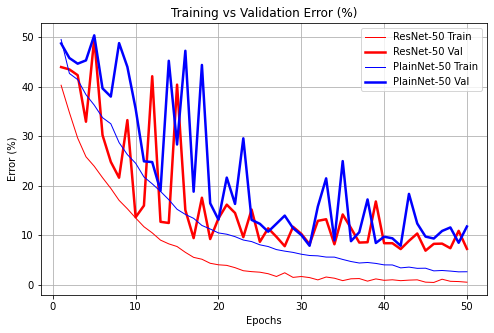

In [ ]:
plt.figure(figsize=(8, 5))
plot_dual_error(history_resnet50, label='ResNet-50', color='red')
plot_dual_error(history_plain50, label='PlainNet-50', color='blue')
plt.xlabel('Epochs')
plt.ylabel('Error (%)')
plt.title('Training vs Validation Error (%)')
plt.legend()
plt.grid(True)
plt.show()


In [ ]:
def plot_accuracy(history, label='Model', color='g'):
    epochs = range(1, len(history.history['accuracy']) + 1)
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']

    # 얇은 선: train / 굵은 선: val
    plt.plot(epochs, acc, linestyle='-', color=color, linewidth=1, label=f'{label} Train')
    plt.plot(epochs, val_acc, linestyle='-', color=color, linewidth=2.5, label=f'{label} Val')

plt.figure(figsize=(8, 5))
plot_accuracy(history_resnet50, label='ResNet-50', color='red')
plot_accuracy(history_plain50, label='PlainNet-50', color='blue')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training vs Validation Accuracy - ResNet-50 vs PlainNet-50')
plt.legend()
plt.grid(True)
plt.show()


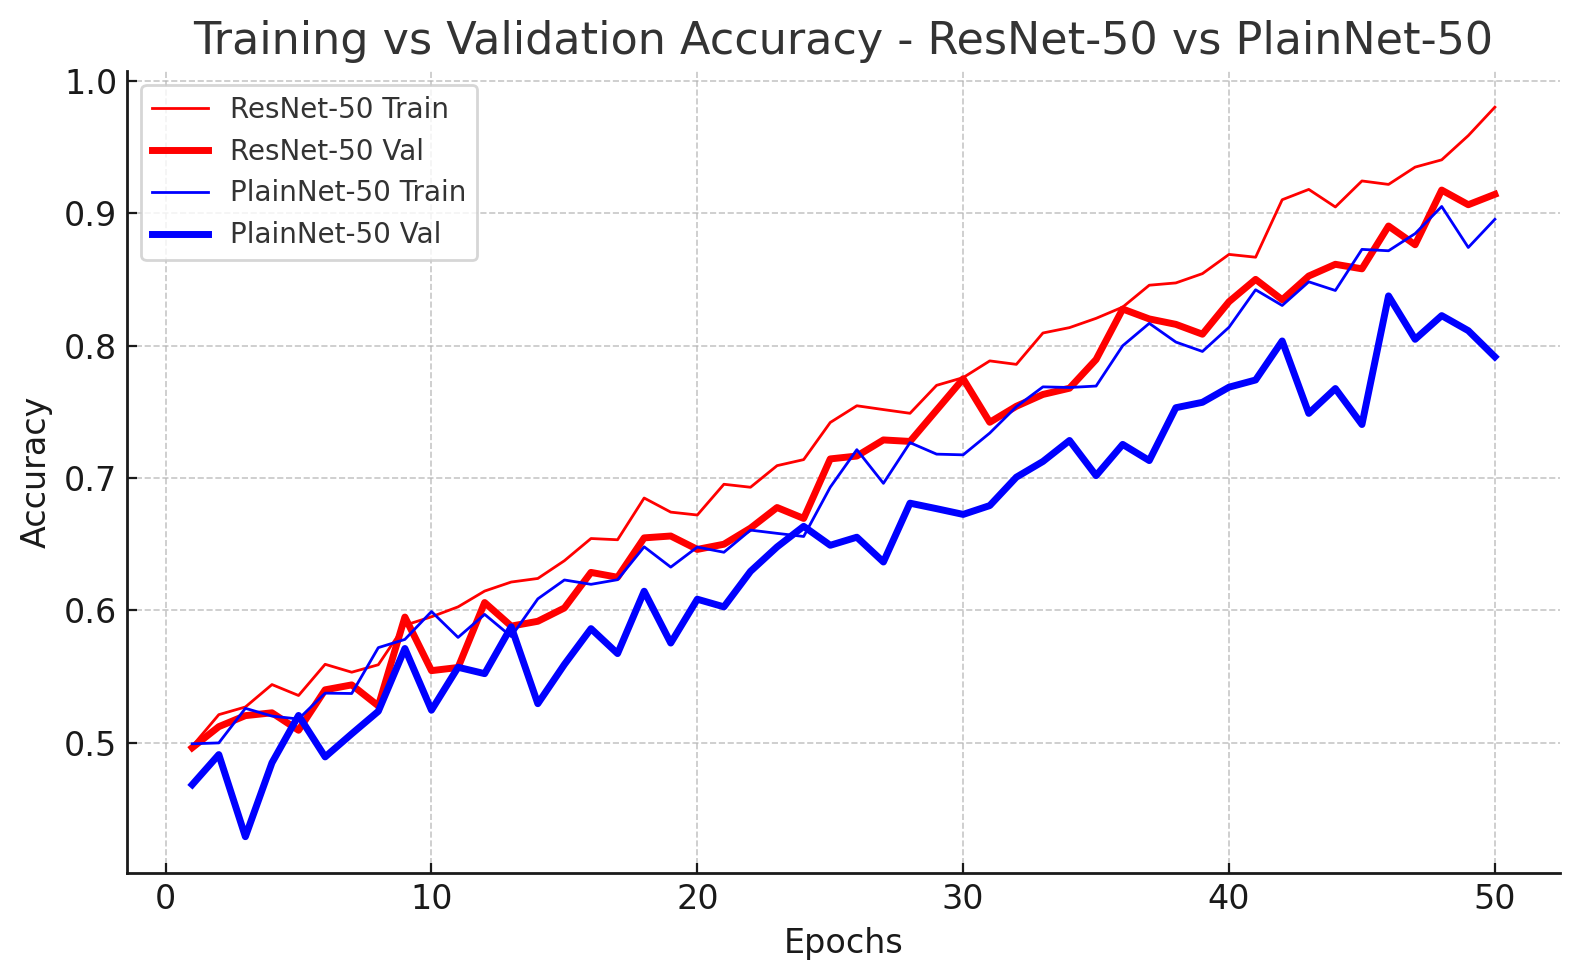

## ResNet-34 vs Plain-34

In [ ]:
# 모델 컴파일
resnet_34.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
plainnet_34.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# 학습 (간단히 5 epoch만)
EPOCHS = 50

history_resnet34 = resnet_34.fit(ds_train, validation_data=ds_val, epochs=EPOCHS)
history_plain34 = plainnet_34.fit(ds_train, validation_data=ds_val, epochs=EPOCHS)

Epoch 1/50
582/582 ━━━━━━━━━━━━━━━━━━━━ 201s 281ms/step - accuracy: 0.5933 - loss: 0.7322 - val_accuracy: 0.5143 - val_loss: 1.5765
Epoch 2/50
582/582 ━━━━━━━━━━━━━━━━━━━━ 134s 227ms/step - accuracy: 0.6683 - loss: 0.6128 - val_accuracy: 0.5706 - val_loss: 1.2703
Epoch 3/50
582/582 ━━━━━━━━━━━━━━━━━━━━ 134s 227ms/step - accuracy: 0.7234 - loss: 0.5466 - val_accuracy: 0.6329 - val_loss: 0.6521
Epoch 4/50
582/582 ━━━━━━━━━━━━━━━━━━━━ 141s 226ms/step - accuracy: 0.7488 - loss: 0.5142 - val_accuracy: 0.6248 - val_loss: 0.7158
Epoch 5/50
582/582 ━━━━━━━━━━━━━━━━━━━━ 143s 227ms/step - accuracy: 0.7883 - loss: 0.4580 - val_accuracy: 0.7178 - val_loss: 0.5591
Epoch 6/50
582/582 ━━━━━━━━━━━━━━━━━━━━ 134s 228ms/step - accuracy: 0.8155 - loss: 0.4158 - val_accuracy: 0.5326 - val_loss: 1.5038
Epoch 7/50
582/582 ━━━━━━━━━━━━━━━━━━━━ 142s 227ms/step - accuracy: 0.8527 - loss: 0.3312 - val_accuracy: 0.8240 - val_loss: 0.3780
Epoch 8/50
582/582 ━━━━━━━━━━━━━━━━━━━━ 152s 259ms/step - accuracy: 0.8761 -

In [ ]:
# ResNet-34 vs PlainNet-34 시각화
plt.figure(figsize=(8, 5))
plot_dual_error(history_resnet34, label='ResNet-34', color='red')
plot_dual_error(history_plain34, label='PlainNet-34', color='blue')
plt.xlabel('Epochs')
plt.ylabel('Error (%)')
plt.title('Training vs Validation Error (%) - ResNet-34 vs PlainNet-34')
plt.legend()
plt.grid(True)
plt.show()

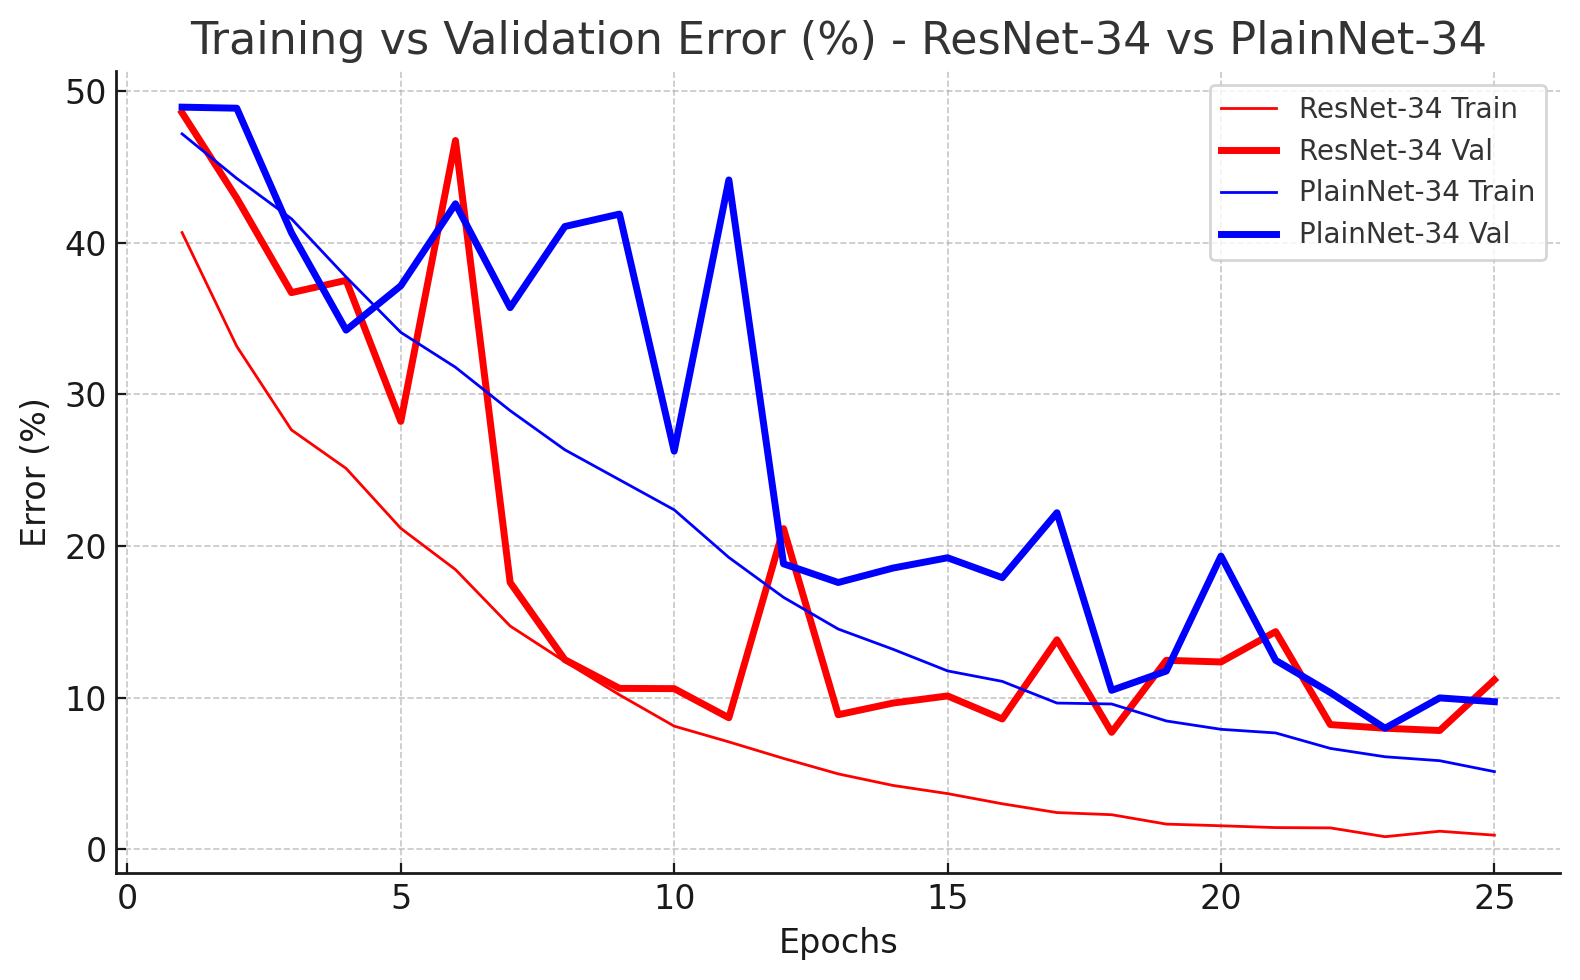

In [ ]:
# ResNet-34 vs PlainNet-34 정확도 시각화
plt.figure(figsize=(8, 5))
plot_accuracy(history_resnet34, label='ResNet-34', color='red')
plot_accuracy(history_plain34, label='PlainNet-34', color='blue')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training vs Validation Accuracy - ResNet-34 vs PlainNet-34')
plt.legend()
plt.grid(True)
plt.show()


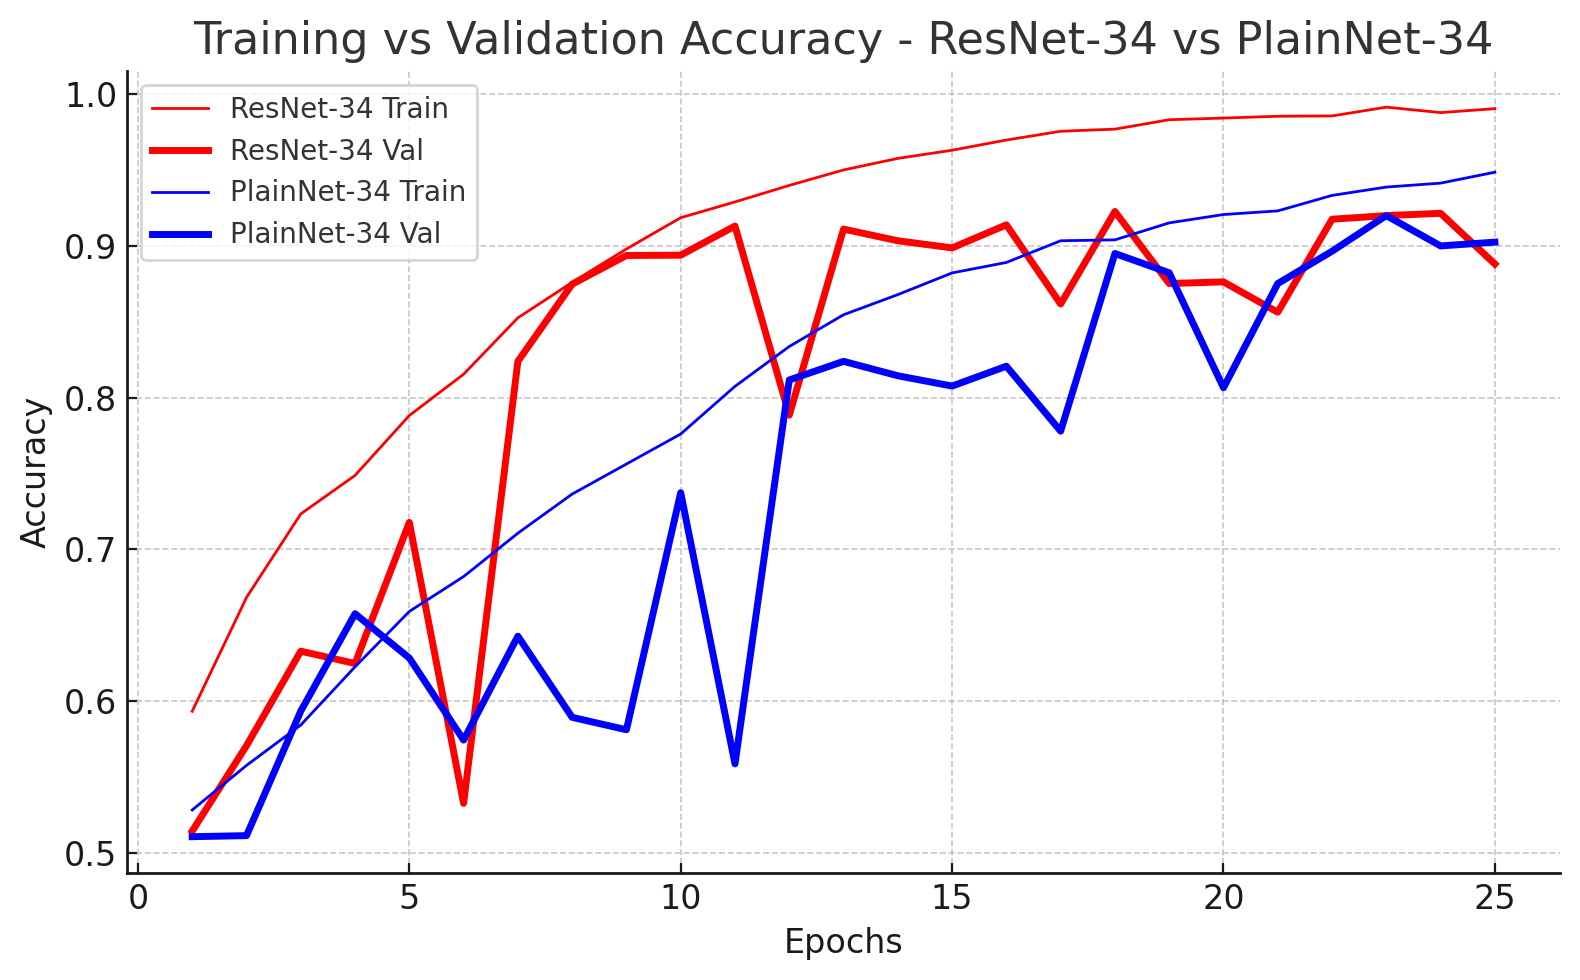

###  Ablation Study Summary

| Epoch 기준 | 비교 항목 | 요약 설명 |
|------------|-----------|-----------|
| 1~50       | Accuracy  | ResNet-50이 더 빠르게 수렴하며 검증 정확도에서도 우세. PlainNet은 검증 정확도에서 변동폭이 크며 과적합 경향이 있음. |
| 1~50       | Error (%) | ResNet은 에러율 감소가 꾸준하고 안정적인 반면, PlainNet은 검증 에러에서 진동 현상이 뚜렷함. |
| 1~25       | Accuracy  | 25 epoch 기준에서도 ResNet이 전반적으로 우세. 초기 수렴 속도와 일반화 능력 모두에서 우위. |
| 1~25       | Error (%) | 초반부터 에러율 차이가 명확히 나타나며, ResNet-34가 PlainNet-34보다 일반화에서 유리한 구조임을 확인. |


- loss 대신 error로 진행했음
- 중간에 연결이 끊겨서 다시 로스의 시각화는 진행하지 못함
- ResNet-50 vs PlainNet-50  은 에폭 50까지 진행했고,   ResNet-34 vs PlainNet-34  에폭 25까지 진행했음.